In [13]:
!pip install duckdb --upgrade

In [14]:
!pip install geopandas

In [15]:
!pip install holidays

In [16]:
%matplotlib inline

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import json
import geopandas as gpd
import holidays



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.dbf
/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shp.xml
/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shp
/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shx
/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.sbx
/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.sbn
/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.prj
/kaggle/input/tlc-trip-record-data-2020-2025/trips/year=2022/cap_type=green/0621641f5af348cbb23d5811260cf036-0.parquet
/kaggle/input/tlc-trip-record-data-2020-2025/trips/year=2022/cap_type=yellow/0621641f5af348cbb23d5811260cf036-0.parquet
/kaggle/input/tlc-trip-record-data-2020-2025/trips/year=2023/cap_type=green/622628e3adf84f7d877ae301ddf462af-0.parquet
/kaggle/input/tlc-trip-record-data-2020-2025/trips/year=2023/cap_type=yellow/622628e3adf84f7d877ae301ddf462af-0.parquet
/kaggle/input/tlc-trip-record-data-2020-2025/trips/year=2025/cap_type=green/861dabb8ae594f54a9757e561a05d786-0.parquet
/kaggle/input/tlc-trip-recor

In [17]:
import duckdb

conn = duckdb.connect()

In [18]:
import shutil

folder_path = '/kaggle/working/iframe_figures'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print('delete folder')
    os.makedirs(folder_path, exist_ok=True)

In [19]:
#import taxi zone lookup table 

taxi_zones = conn.sql("CREATE OR REPLACE TABLE taxi_zones as select * from read_csv_auto('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv')")
conn.sql("select * from taxi_zones limit 5").show()

┌────────────┬───────────────┬─────────────────────────┬──────────────┐
│ LocationID │    Borough    │          Zone           │ service_zone │
│   int64    │    varchar    │         varchar         │   varchar    │
├────────────┼───────────────┼─────────────────────────┼──────────────┤
│          1 │ EWR           │ Newark Airport          │ EWR          │
│          2 │ Queens        │ Jamaica Bay             │ Boro Zone    │
│          3 │ Bronx         │ Allerton/Pelham Gardens │ Boro Zone    │
│          4 │ Manhattan     │ Alphabet City           │ Yellow Zone  │
│          5 │ Staten Island │ Arden Heights           │ Boro Zone    │
└────────────┴───────────────┴─────────────────────────┴──────────────┘



In [20]:
#import taxi zone gdf shapefile
taxi_zones_gdf = gpd.read_file('/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shp')

# Cleanning Data Set

In [21]:
#total records before cleaning

query = """
select 
    cap_type
    ,count(*) AS row_count
from read_parquet('/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet', hive_partitioning=true)
group by cap_type
"""
conn.sql (query).df()

,cap_type,row_count
0,yellow,178164670
1,green,5138937


In [22]:
#creating view for yellow taxi

conn.sql("""
create or replace VIEW clean_yellow_trips as
select 
    'yellow' as cap_type
    ,tpep_pickup_datetime as pickup_datetime
    ,tpep_dropoff_datetime as dropoff_datetime
    ,strftime(tpep_pickup_datetime, '%Y') as p_year
    ,strftime(tpep_pickup_datetime, '%Y-%m') as pickup_year_month
    ,strftime(pickup_datetime, '%a') as pickup_weekday
    ,strftime(tpep_pickup_datetime, '%H') as pickup_hour
    ,strftime(tpep_pickup_datetime, '%a') || '_' || strftime(tpep_pickup_datetime, '%H') as pickup_day_hour
    ,strftime(tpep_pickup_datetime, '%Y') || '_' || strftime(tpep_pickup_datetime, '%a') || '_' || strftime(tpep_pickup_datetime, '%H') as year_day_hour
    ,(case
        when strftime('%m-%d', pickup_datetime) between '03-20' and '06-19' then 'Spring'
        when strftime('%m-%d', pickup_datetime) between '06-20' and '09-21' then 'Summer'
        when strftime('%m-%d', pickup_datetime) between '09-22' and '12-20' then 'Autumn'
        else 'Winter'
    end) as season
    ,round(EXTRACT(epoch FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 ,1)as trip_duration_minutes
    ,passenger_count
    ,trip_distance
    ,fare_amount
    ,tolls_amount
    ,extra
    ,mta_tax
    ,tip_amount
    ,congestion_surcharge
    ,airport_fee
    ,improvement_surcharge
    ,total_amount
    ,payment_type
    ,PULocationID as pickup_location_id
    ,DOLocationID as dropoff_location_id
    ,RatecodeID
from read_parquet('/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet', hive_partitioning=true)
where 1=1
    and tpep_pickup_datetime >= '2020-01-01 00:00:00'
    and tpep_pickup_datetime < '2025-02-01 00:00:00'
    and LOWER(cap_type) = 'yellow'
    and fare_amount between 3 and 200
    and trip_distance between 0.5 and 100 
    and passenger_count between 1 and 6 
    and tpep_dropoff_datetime >= tpep_pickup_datetime 
    and tpep_pickup_datetime IS NOT NULL
    and tpep_dropoff_datetime IS NOT NULL
    and EXTRACT(epoch from (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 between 1 and 120
""")
conn.sql("""
select * from clean_yellow_trips limit 3;
""").df()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,cap_type,pickup_datetime,dropoff_datetime,p_year,pickup_year_month,pickup_weekday,pickup_hour,pickup_day_hour,year_day_hour,season,...,mta_tax,tip_amount,congestion_surcharge,airport_fee,improvement_surcharge,total_amount,payment_type,pickup_location_id,dropoff_location_id,RatecodeID
0,yellow,2020-01-01 00:28:15,2020-01-01 00:33:03,2020,2020-01,Wed,00,Wed_00,2020_Wed_00,Winter,...,0.5,1.47,2.5,NaN,0.3,11.27,1.0,238,239,1.0
1,yellow,2020-01-01 00:35:39,2020-01-01 00:43:04,2020,2020-01,Wed,00,Wed_00,2020_Wed_00,Winter,...,0.5,1.50,2.5,NaN,0.3,12.30,1.0,239,238,1.0
2,yellow,2020-01-01 00:47:41,2020-01-01 00:53:52,2020,2020-01,Wed,00,Wed_00,2020_Wed_00,Winter,...,0.5,1.00,2.5,NaN,0.3,10.80,1.0,238,238,1.0


In [23]:
_d = conn.sql("""
SELECT 
    pickup_datetime,
    dropoff_datetime,
    pickup_location_id,
    dropoff_location_id,
    passenger_count,
    trip_distance,
    fare_amount,
    total_amount,
    tip_amount,
    RatecodeID,
    COUNT(*) as count
FROM clean_yellow_trips
GROUP BY 
    pickup_datetime,
    dropoff_datetime,
    pickup_location_id,
    dropoff_location_id,
    passenger_count,
    trip_distance,
    fare_amount,
    total_amount,
    RatecodeID,
    tip_amount
HAVING count > 1
""").df()
_d

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,passenger_count,trip_distance,fare_amount,total_amount,tip_amount,RatecodeID,count
0,2024-10-22 15:37:55,2024-10-22 15:54:54,141,263,1.0,1.30,14.9,21.90,3.00,1.0,2
1,2024-02-08 18:23:50,2024-02-08 18:38:14,162,230,1.0,0.81,12.8,23.16,3.86,1.0,2
2,2023-11-13 13:26:12,2023-11-13 14:48:41,230,132,1.0,18.87,70.0,97.13,16.19,2.0,2
3,2023-11-13 13:57:30,2023-11-13 14:54:16,10,239,1.0,18.02,70.0,85.94,0.00,2.0,2


In [24]:
#creating view for green taxi

conn.sql("""
create or replace VIEW clean_green_trips as
select 
    'green' as cap_type
    ,lpep_pickup_datetime as pickup_datetime
    ,lpep_dropoff_datetime as dropoff_datetime
    ,strftime(lpep_pickup_datetime, '%Y') as p_year
    ,strftime(lpep_pickup_datetime, '%Y-%m') as pickup_year_month
    ,strftime(pickup_datetime, '%a') as pickup_weekday
    ,strftime(lpep_pickup_datetime, '%H') as pickup_hour
    ,strftime(lpep_pickup_datetime, '%a') || '_' || strftime(lpep_pickup_datetime, '%H') as pickup_day_hour
    ,(case
        when strftime('%m-%d', pickup_datetime) between '03-20' and '06-19' then 'Spring'
        when strftime('%m-%d', pickup_datetime) between '06-20' and '09-21' then 'Summer'
        when strftime('%m-%d', pickup_datetime) between '09-22' and '12-20' then 'Autumn'
        else 'Winter'
    end) as season
    ,round(EXTRACT(epoch FROM (lpep_dropoff_datetime - lpep_pickup_datetime)) / 60 ,1)as trip_duration_minutes
    ,passenger_count
    ,trip_distance
    ,fare_amount
    ,extra
    ,mta_tax
    ,tip_amount
    ,congestion_surcharge
    ,improvement_surcharge
    ,total_amount
    ,payment_type
    ,PULocationID as pickup_location_id
    ,DOLocationID as dropoff_location_id
    ,RatecodeID
    ,trip_type
from read_parquet('/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet', hive_partitioning=true)
where 1=1
    and p_year between '2020' and '2025'
    and LOWER(cap_type) = 'green'
    and fare_amount between 3 and 200 
    and trip_distance between 0.5 and 100 
    and passenger_count between 1 and 6 
    and lpep_dropoff_datetime >= lpep_pickup_datetime 
    and lpep_pickup_datetime IS NOT NULL
    and lpep_dropoff_datetime IS NOT NULL
    and EXTRACT(epoch from (lpep_dropoff_datetime - lpep_pickup_datetime)) / 60 between 1 and 120
""")
conn.sql("""
select * from clean_green_trips limit 3;
""").df()

,cap_type,pickup_datetime,dropoff_datetime,p_year,pickup_year_month,pickup_weekday,pickup_hour,pickup_day_hour,season,trip_duration_minutes,...,mta_tax,tip_amount,congestion_surcharge,improvement_surcharge,total_amount,payment_type,pickup_location_id,dropoff_location_id,RatecodeID,trip_type
0,green,2020-01-01 00:45:58,2020-01-01 00:56:39,2020,2020-01,Wed,00,Wed_00,Winter,10.7,...,0.0,4.06,0.00,0.3,24.36,1.0,66,65,5.0,2.0
1,green,2020-01-01 00:41:38,2020-01-01 00:52:49,2020,2020-01,Wed,00,Wed_00,Winter,11.2,...,0.5,3.54,0.00,0.3,15.34,1.0,181,228,1.0,1.0
2,green,2020-01-01 00:52:46,2020-01-01 01:14:21,2020,2020-01,Wed,00,Wed_00,Winter,21.6,...,0.5,0.00,2.75,0.3,25.05,2.0,129,263,1.0,1.0


# Trips Monthly Trend 

In [25]:

trend = conn.sql("""
select
    strftime(pickup_datetime, '%m') as month
    ,count(*) as total_trip
from clean_yellow_trips
where p_year = '2024'
group by 1
order by 1
""").df()



fig = px.line(
    trend,
    x='month',
    y='total_trip',
    title='Monthly Pickups-2024',
    markers=True,
)

fig.update_layout(
    xaxis_tickangle=45,
    width=900,
    height=500,
    hovermode='x unified',
    margin=dict(b=150),
    title_x=0.5 
)

fig.show(renderer='iframe')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [26]:


# Modified SQL query to include all years
trend = conn.sql("""
SELECT
    strftime(pickup_datetime, '%Y') as year,
    strftime(pickup_datetime, '%m') as month,
    count(*) as total_trip
FROM clean_yellow_trips
GROUP BY year, month
ORDER BY year, month
""").df()

# Create line chart with different lines for each year
fig = px.line(
    trend,
    x='month',
    y='total_trip',
    color='year',  # Differentiate lines by year
    title='Monthly Pickups',
    markers=True,
)

fig.update_layout(
    xaxis_tickangle=45,
    width=900,
    height=500,
    hovermode='x unified',
    margin=dict(b=150),
    title_x=0.5 
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/monthly_pickups.html')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:

trend = conn.sql("""
select
    strftime('%d', pickup_datetime) as day
    ,pickup_weekday
    ,count(*) as total_trip
from clean_yellow_trips
where pickup_year_month = '2024-02'
group by 1, 2
order by 1
""").df()


# define day-week day
trend['day_label'] = trend['day'].astype(int).astype(str).str.zfill(2) + ' - ' + trend['pickup_weekday']

fig = px.line(
    trend,
    x='day_label',
    y='total_trip',
    title='Taxi Trips per Day (with Weekday) - Feb 2024',
    labels={'day_label': 'Day - Weekday', 'total_trip': 'Number of Trips'},
    markers=True,
)

fig.update_layout(
    xaxis_tickangle=45,
    width=900,
    height=500,
    hovermode='x unified',
    margin=dict(b=150)
)

fig.show(renderer='iframe')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# Trip distribution by day

In [28]:
# Step 1: Query average trips per weekday per year
y_pick_up_day_avg= conn.sql("""
SELECT 
    p_year,
    pickup_weekday,
    AVG(daily_trips) AS avg_trips
FROM (
    SELECT 
        p_year,
        pickup_weekday,
        pickup_date,
        COUNT(*) AS daily_trips
    FROM (
        SELECT 
            p_year,
            pickup_weekday,
            CAST(pickup_datetime AS DATE) AS pickup_date
        FROM clean_yellow_trips

        UNION ALL

        SELECT 
            p_year,
            pickup_weekday,
            CAST(pickup_datetime AS DATE) AS pickup_date
        FROM clean_green_trips
    ) all_trips
    GROUP BY p_year, pickup_weekday, pickup_date
) daily_data
GROUP BY p_year, pickup_weekday
ORDER BY p_year, pickup_weekday
""").df()

# Define weekday order
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y_pick_up_day_avg['pickup_weekday'] = pd.Categorical(y_pick_up_day_avg['pickup_weekday'], categories=weekday_order, ordered=True)

# Sort before plotting
y_pick_up_day_avg = y_pick_up_day_avg.sort_values(['p_year', 'pickup_weekday'])

# Plot line chart
fig = px.line(
    y_pick_up_day_avg,
    x='pickup_weekday',
    y='avg_trips',
    color='p_year',
    markers=True,
    labels={'pickup_weekday': 'Day of Week', 'avg_trips': 'Average Daily Trips', 'p_year': 'Year'},
    title='Average Daily Taxi Trips per Weekday'
)

fig.update_layout(
    xaxis_title='Weekday',
    yaxis_title='Average Number of Trips',
    title_x=0.5,
    template='plotly_white'
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/Avg_Trips_per_weekday.html')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [29]:
y_pick_up_day = conn.sql ("""
select 
    p_year
    ,pickup_weekday
    ,sum(total_trips) as total_trips
from (
    select 
        p_year
        ,pickup_weekday
        ,count(*) as total_trips
    from clean_yellow_trips
    group by 1,2

    UNION ALL

    select 
        p_year
        ,pickup_weekday
        ,count(*) as total_trips
    from clean_green_trips
    group by 1,2
) as unioned
group by 1,2
order by 1,2

""").df()

# plotly
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y_pick_up_day['pickup_weekday'] = pd.Categorical(y_pick_up_day['pickup_weekday'], categories=weekday_order, ordered=True)

fig = px.line(
    y_pick_up_day.sort_values(['p_year', 'pickup_weekday']),
    x='pickup_weekday',
    y='total_trips',
    color='p_year',
    markers=True,
    labels={'pickup_weekday': 'Day of Week', 'total_trips': 'Total Trips', 'p_year': 'Year'},
    title='Trip Distribution based on Day of Week'
)

fig.update_layout(
    xaxis_title='Weekday',
    yaxis_title='Total Trips',
    title_x=0.5,
    template='plotly_white'
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/Total_Trips_per_weekday.html')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

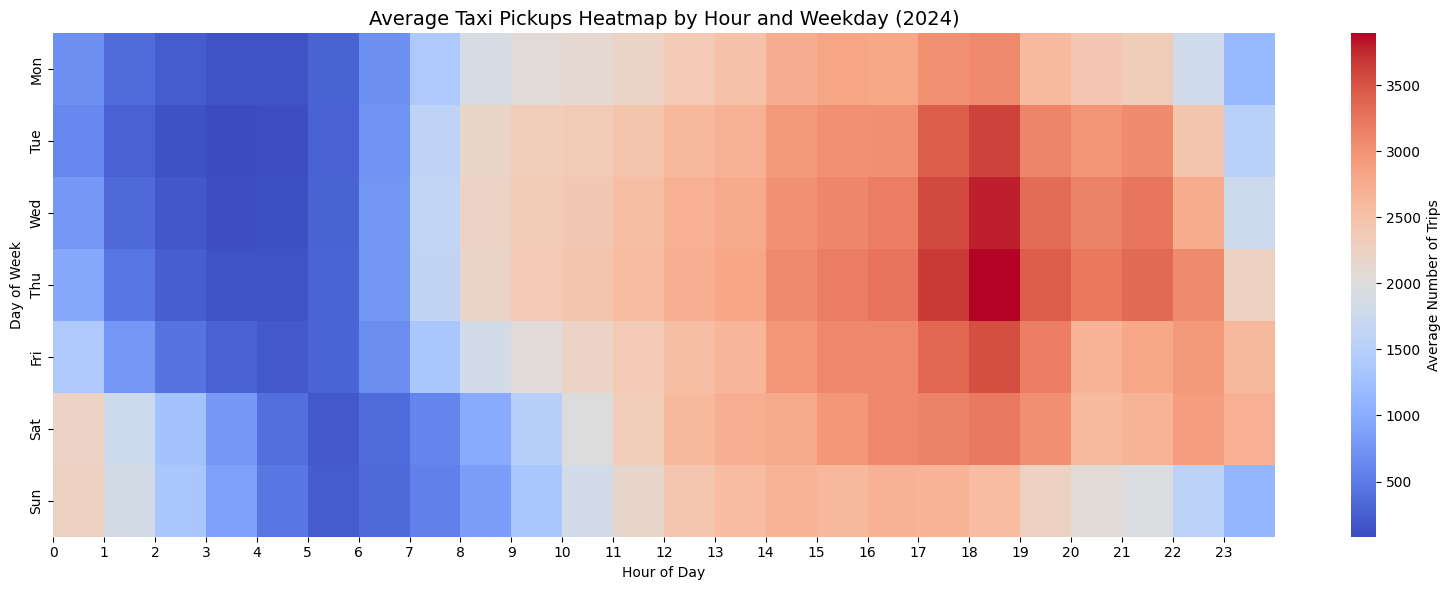

In [30]:
pickup_day_hour = conn.sql("""
select 
    pickup_weekday
    ,pickup_hour
    ,avg(hourly_trips) as avg_trips
from (
    select 
        pickup_weekday
        ,pickup_hour
        ,cast(pickup_datetime as date) as pickup_date
        ,count(*) as hourly_trips
    from clean_yellow_trips
    where p_year = 2024
    group by 1,2,3

    union all

    select 
        pickup_weekday
        ,pickup_hour
        ,cast(pickup_datetime as date) as pickup_date
        ,count(*) as hourly_trips
    from clean_green_trips
    where p_year = 2024
    group by 1,2,3
) all_data
group by 1,2
order by 1,2
""").df()

weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pickup_day_hour['pickup_weekday'] = pd.Categorical(pickup_day_hour['pickup_weekday'], categories=weekday_order, ordered=True)
pickup_day_hour['pickup_hour'] = pickup_day_hour['pickup_hour'].astype(int)

heatmap_data = pickup_day_hour.pivot(index='pickup_weekday', columns='pickup_hour', values='avg_trips')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,6))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    annot=False,
    cbar_kws={'label': 'Average Number of Trips'}
)

plt.title('Average Taxi Pickups Heatmap by Hour and Weekday (2024)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.xticks(ticks=range(24), labels=[str(h) for h in range(24)])
plt.tight_layout()
plt.show()

# count of trips

In [31]:
#count of green trips

green_count = conn.sql("""
select 
    p_year
    ,count(pickup_location_id) as total_trips 
from clean_green_trips 
group by 1
order by 1
""").df()
print(f'count of green taxi trips')
green_count

count of green taxi trips


,p_year,total_trips
0,2020,1077264
1,2021,588770
2,2022,666058
3,2023,657465
4,2024,568977
5,2025,41383


In [32]:
#count of yellow trips

yellow_count = conn.sql ("""
select 
    p_year
    ,count(pickup_location_id) as total_trips 
from clean_yellow_trips 
group by 1
order by 1
""").df()
print(f'count of yellow taxi trips')
yellow_count

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

count of yellow taxi trips


,p_year,total_trips
0,2020,21890775
1,2021,27243167
2,2022,35586673
3,2023,34253555
4,2024,34059984
5,2025,2685019


In [33]:
# Merge counts
stacked = yellow_count.merge(
    green_count,
    on='p_year',
    how='outer',
    suffixes=('_yellow', '_green')
).fillna(0)

stacked['yellow_million'] = (stacked['total_trips_yellow'] / 1_000_000).round(1)
stacked['green_million'] = (stacked['total_trips_green'] / 1_000_000).round(1)


fig = go.Figure()

# Yellow taxi line
fig.add_trace(go.Scatter(
    x=stacked['p_year'],
    y=stacked['yellow_million'],
    mode='lines+markers+text',
    name='Yellow Taxi',
    text=stacked['yellow_million'],
    textposition='top center',
    line=dict(color='gold', width=3),
    marker=dict(size=8)
))

# Green taxi line
fig.add_trace(go.Scatter(
    x=stacked['p_year'],
    y=stacked['green_million'],
    mode='lines+markers+text',
    name='Green Taxi',
    text=stacked['green_million'],
    textposition='top center',
    line=dict(color='green', width=3),
    marker=dict(size=8)
))

fig.update_layout(
    title={
        'text': 'Total Taxi Trips per Cab Type',
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=20, family='Arial', color='black')
    },
    xaxis_title='Year',
    yaxis_title='Number of Trips (Million)',
    margin=dict(b=100),
    width=900,
    height=600,
    template='simple_white',
    hovermode='x unified'
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/Total_Taxi_Trips_per_type.html')

# Share of cabs

In [34]:
# Merge the yellow and green counts on the year
combined = yellow_count.merge(green_count, on='p_year', how='outer', suffixes=('_yellow', '_green')).fillna(0)

# Calculate total trips
combined['total_trips_all'] = combined['total_trips_yellow'] + combined['total_trips_green']

# Calculate percentages
combined['yellow_percent'] = (combined['total_trips_yellow'] / combined['total_trips_all'])*100 
combined['green_percent'] = (combined['total_trips_green'] / combined['total_trips_all'])*100


# Round percentages to 1 decimal place
combined['yellow_percent'] = combined['yellow_percent'].round(1)
combined['green_percent'] = combined['green_percent'].round(1)

fig = go.Figure()

# Add Yellow Taxi bar (custom yellow color)
fig.add_trace(go.Bar(
    x=combined['p_year'],
    y=combined['yellow_percent'],
    name='Yellow Taxi',
    text=combined['yellow_percent'],
    textposition='auto',
    marker_color='gold'  # or use '#FFD700'
))

# Add Green Taxi bar
fig.add_trace(go.Bar(
    x=combined['p_year'],
    y=combined['green_percent'],
    name='Green Taxi',
    text=combined['green_percent'],
    textposition='auto',
    marker_color='green'
))

# Update layout (remove percent format from y-axis)
fig.update_layout(
    barmode='stack',
    title='Share of Yellow vs Green Taxi Trips',
    xaxis_title='Year',
    yaxis_title='Share of Trips',
    yaxis_tickformat=',.1f',  # plain number with 1 decimal
    template='simple_white',
    title_x=0.5,
    
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/Share_of_cab.html')

# fare amount

In [35]:
#yellow trips fare amount describe 

yellow_fare = """
select 
    p_year
    ,round(min(fare_amount),1) as min_fare_amount 
    ,round(max(fare_amount),1) as max_fare_amount 
    ,round(avg(fare_amount),1) as avg_fare_amount 
    ,round(percentile_cont(0.5) within group (order by fare_amount), 1) as p50_fare_amount
    ,round(percentile_cont(0.75) within group (order by fare_amount), 1) as p75_fare_amount
    ,round(percentile_cont(0.95) within group (order by fare_amount), 1) as p95_fare_amount
    from clean_yellow_trips 
group by 1
"""
conn.sql(yellow_fare).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p_year,min_fare_amount,max_fare_amount,avg_fare_amount,p50_fare_amount,p75_fare_amount,p95_fare_amount
0,2025,3.0,200.0,18.3,12.8,19.8,59.7
1,2020,3.0,200.0,12.2,9.0,13.5,32.0
2,2022,3.0,200.0,14.8,10.5,16.5,52.0
3,2021,3.0,200.0,13.1,9.5,14.5,36.0
4,2023,3.0,200.0,20.1,14.2,22.6,70.0
5,2024,3.0,200.0,20.1,14.2,22.6,70.0


In [36]:
# green trips fare amount describe  

green_fare = """
select 
    p_year
    ,round(min(fare_amount),1) as min_fare_amount 
    ,round(max(fare_amount),1) as max_fare_amount 
    ,round(avg(fare_amount),1) as avg_fare_amount 
    ,round(percentile_cont(0.5) within group (order by fare_amount), 1) as p50_fare_amount
    ,round(percentile_cont(0.75) within group (order by fare_amount), 1) as p75_fare_amount
    ,round(percentile_cont(0.95) within group (order by fare_amount), 1) as p95_fare_amount
from clean_green_trips 
group by 1
"""
conn.sql(green_fare).df()

,p_year,min_fare_amount,max_fare_amount,avg_fare_amount,p50_fare_amount,p75_fare_amount,p95_fare_amount
0,2025,4.4,192.0,16.4,12.8,18.4,37.3
1,2021,3.0,200.0,15.5,11.0,17.5,46.5
2,2023,3.0,200.0,17.5,13.5,20.5,41.5
3,2024,3.0,200.0,17.8,13.5,20.0,42.2
4,2020,3.0,200.0,12.8,9.5,14.5,32.0
5,2022,3.0,200.0,13.9,10.5,16.0,33.0


# 2025 Fare Distribution

In [37]:
# CPI Adjustment Factors (base year = 2024)
cpi_adjustment = {
    2020: 0.846,
    2021: 0.874,
    2022: 0.928,
    2023: 0.963,
    2024: 1.0000,
    2025: 1.025
}

# Filter data for year 2025
yellow_df_2025 = conn.sql("SELECT p_year, fare_amount FROM clean_yellow_trips WHERE p_year = 2025").df()
green_df_2025 = conn.sql("SELECT p_year, fare_amount FROM clean_green_trips WHERE p_year = 2025").df()

# Calculate adjusted fare for 2025
yellow_df_2025['adjusted_fare'] = yellow_df_2025['fare_amount'] * cpi_adjustment[2025]
green_df_2025['adjusted_fare'] = green_df_2025['fare_amount'] * cpi_adjustment[2025]

# Define fare bins
bins = [0, 10, 20, 50, 200, float('inf')]
labels = ['0-10 (Cheap)', '10-20 (Moderate)', '20-50 (Expensive)', '50-200 (Very Expensive)', '>200 (Extremely Expensive)']

# Categorize adjusted fare for yellow taxis
yellow_df_2025['fare_bin'] = pd.cut(yellow_df_2025['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
yellow_stats25 = yellow_df_2025.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(yellow_df_2025) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
yellow_stats25['fare_percentage'] = yellow_stats25['total_fare'] / yellow_stats25['total_fare'].sum() * 100

# Categorize adjusted fare for green taxis
green_df_2025['fare_bin'] = pd.cut(green_df_2025['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
green_stats25 = green_df_2025.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(green_df_2025) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
green_stats25['fare_percentage'] = green_stats25['total_fare'] / green_stats25['total_fare'].sum() * 100

# Print output for 2025
print("\nYellow Taxi Fare Distribution for 2025 (Adjusted to 2024 USD):")
print(yellow_stats25.round(2))
print("\nGreen Taxi Fare Distribution for 2025 (Adjusted to 2024 USD):")
print(green_stats25.round(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Yellow Taxi Fare Distribution for 2025 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage   total_fare  fare_percentage
0                0-10 (Cheap)            29.82   6249611.81            12.38
1            10-20 (Moderate)            44.60  16605890.63            32.89
2           20-50 (Expensive)            19.29  15523730.39            30.74
3     50-200 (Very Expensive)             6.29  12088382.00            23.94
4  >200 (Extremely Expensive)             0.00     24655.66             0.05

Green Taxi Fare Distribution for 2025 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage  total_fare  fare_percentage
0                0-10 (Cheap)            26.29    87194.19            12.55
1            10-20 (Moderate)            50.84   295990.49            42.61
2           20-50 (Expensive)            20.40   240074.76            34.56
3     50-200 (Very Expensive)             2.47    71377.76            10.28
4  >200 (Extremely Expensive)  

/tmp/ipykernel_31/1638519417.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_31/1638519417.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [38]:
yellow_stats25['formatted_percentage'] = yellow_stats25['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(yellow_stats25,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Yellow Fare Distribution Per Trip Percentage (2025)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.YlOrBr,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Yellow Fare Distribution Per Trip Percentage (2025)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')

In [39]:
green_stats25['formatted_percentage'] = green_stats25['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(green_stats25,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Green Fare Distribution Per Trip Percentage (2025)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.Greens,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Green Fare Distribution Per Trip Percentage (2025)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')

# 2024 Fare Distribution

In [40]:
#fare distribution per trip count (2024)

# filter year 
yellow_df_2024 = conn.sql("select fare_amount from clean_yellow_trips where p_year = 2024").df()
green_df_2024 = conn.sql("select fare_amount from clean_green_trips where p_year = 2024").df()

#define bins
bins = [0, 10, 20, 50, 200, float('inf')]
labels = ['0-10 (Cheap)', '10-20 (Moderate)', '20-50 (Expensive)', '50-200 (Very Expensive)', '>200 (Extremely Expensive)']

# categorize fares for yellow
yellow_df_2024['fare_bin'] = pd.cut(yellow_df_2024['fare_amount'], bins=bins, labels=labels, include_lowest=True)
yellow_bin_stats_24 = yellow_df_2024.groupby('fare_bin').agg(
    trip_percentage=('fare_amount', lambda x: len(x) / len(yellow_df_2024) * 100),       # trip percentage
    total_fare=('fare_amount', 'sum'),                                              # sum of fare
).reindex(labels)

yellow_bin_stats_24 = yellow_bin_stats_24.reset_index()

# add fare percentage column
yellow_bin_stats_24['fare_percentage'] = yellow_bin_stats_24['total_fare'] / yellow_bin_stats_24['total_fare'].sum() * 100

# categorize fares for yellow
green_df_2024['fare_bin'] = pd.cut(green_df_2024['fare_amount'], bins=bins, labels=labels, include_lowest=True)
green_bin_stats_24 = green_df_2024.groupby('fare_bin').agg(
    trip_percentage=('fare_amount', lambda x: len(x) / len(green_df_2024) * 100),        #trip percentage
    total_fare=('fare_amount', 'sum'),                                             # sum of fare
).reindex(labels)

green_bin_stats_24 = green_bin_stats_24.reset_index()

# add fare percentage column
green_bin_stats_24['fare_percentage'] = green_bin_stats_24['total_fare'] / green_bin_stats_24['total_fare'].sum() * 100

print("Yellow Taxi Fare Distribution (% of trips and total fare in 2024):")
print(yellow_bin_stats_24.round(2))
print("\nGreen Taxi Fare Distribution (% of trips and total fare in 2024):")
print(green_bin_stats_24.round(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_31/4190247038.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Yellow Taxi Fare Distribution (% of trips and total fare in 2024):
                     fare_bin  trip_percentage    total_fare  fare_percentage
0                0-10 (Cheap)            29.72  8.112973e+07            11.83
1            10-20 (Moderate)            40.85  1.999054e+08            29.14
2           20-50 (Expensive)            21.90  2.249780e+08            32.79
3     50-200 (Very Expensive)             7.52  1.800357e+08            26.24
4  >200 (Extremely Expensive)             0.00  0.000000e+00             0.00

Green Taxi Fare Distribution (% of trips and total fare in 2024):
                     fare_bin  trip_percentage  total_fare  fare_percentage
0                0-10 (Cheap)            28.34  1322500.31            13.06
1            10-20 (Moderate)            46.68  3849039.98            38.00
2           20-50 (Expensive)            21.74  3622606.74            35.77
3     50-200 (Very Expensive)             3.25  1334377.49            13.17
4  >200 (Extremely

/tmp/ipykernel_31/4190247038.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [41]:
yellow_bin_stats_24['formatted_percentage'] = yellow_bin_stats_24['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(yellow_bin_stats_24,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Yellow Fare Distribution Per Trip Percentage (2024)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.YlOrBr,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Fare Distribution Per Trip Percentage (2024)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/yfare_2024.html')

In [42]:
green_bin_stats_24['formatted_percentage'] = green_bin_stats_24['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(green_bin_stats_24,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Green Fare Distribution Per Trip Percentage (2024)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.Greens,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Green Fare Distribution Per Trip Percentage (2024)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/gfare_2024.html')

# 2023 Fare Distribution

In [43]:
# CPI Adjustment Factors (base year = 2024)
cpi_adjustment = {
    2020: 0.846,
    2021: 0.874,
    2022: 0.928,
    2023: 0.963,
    2024: 1.0000,
    2025: 1.025
}

# filter year 
yellow_df_2023 = conn.sql("select p_year,fare_amount from clean_yellow_trips where p_year = 2023").df()
green_df_2023 = conn.sql("select p_year, fare_amount from clean_green_trips where p_year = 2023").df()

# adjusted fare
yellow_df_2023['adjusted_fare'] = yellow_df_2023['fare_amount'] * cpi_adjustment[2023]
green_df_2023['adjusted_fare'] = green_df_2023['fare_amount'] * cpi_adjustment[2023]

#define bins
bins = [0, 10, 20, 50, 200, float('inf')]
labels = ['0-10 (Cheap)', '10-20 (Moderate)', '20-50 (Expensive)', '50-200 (Very Expensive)', '>200 (Extremely Expensive)']

#yellow
yellow_df_2023['fare_bin'] = pd.cut(yellow_df_2023['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
yellow_stats23 = yellow_df_2023.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(yellow_df_2023) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
yellow_stats23['fare_percentage'] = yellow_stats23['total_fare'] / yellow_stats23['total_fare'].sum() * 100

#green
green_df_2023['fare_bin'] = pd.cut(green_df_2023['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
green_stats23 = green_df_2023.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(green_df_2023) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
green_stats23['fare_percentage'] = green_stats23['total_fare'] / green_stats23['total_fare'].sum() * 100

print("\nYellow Taxi Fare Distribution for 2023 (Adjusted to 2024 USD):")
print(yellow_stats23.round(2))
print("\nGreen Taxi Fare Distribution for 2023 (Adjusted to 2024 USD):")
print(green_stats23.round(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_31/3506506980.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Yellow Taxi Fare Distribution for 2023 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage    total_fare  fare_percentage
0                0-10 (Cheap)            29.74  7.860510e+07            11.87
1            10-20 (Moderate)            42.55  2.045397e+08            30.89
2           20-50 (Expensive)            20.46  2.101525e+08            31.74
3     50-200 (Very Expensive)             7.24  1.688060e+08            25.50
4  >200 (Extremely Expensive)             0.00  0.000000e+00             0.00

Green Taxi Fare Distribution for 2023 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage  total_fare  fare_percentage
0                0-10 (Cheap)            29.69  1534274.33            13.84
1            10-20 (Moderate)            46.80  4341139.81            39.17
2           20-50 (Expensive)            20.77  3961811.90            35.75
3     50-200 (Very Expensive)             2.74  1245907.11            11.24
4  >200 (Extremely Expens

/tmp/ipykernel_31/3506506980.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**yellow fare distribution**

In [44]:
yellow_stats23['formatted_percentage'] = yellow_stats23['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(yellow_stats23,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Yellow Fare Distribution Per Trip Percentage (2023)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.YlOrBr,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Yellow Fare Distribution Per Trip Percentage (2023)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')

**green fare distribution**

In [45]:
#2023
green_stats23['formatted_percentage'] = green_stats23['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(green_stats23,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Green Fare Distribution Per Trip Percentage (2023)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.Greens,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    )
)

fig.show(renderer='iframe')

# 2022 Fare Distribution

In [46]:
# CPI Adjustment Factors (base year = 2024)
cpi_adjustment = {
    2020: 0.846,
    2021: 0.874,
    2022: 0.928,
    2023: 0.963,
    2024: 1.0000,
    2025: 1.025
}

# Filter data for year 2022
yellow_df_2022 = conn.sql("SELECT p_year, fare_amount FROM clean_yellow_trips WHERE p_year = 2022").df()
green_df_2022 = conn.sql("SELECT p_year, fare_amount FROM clean_green_trips WHERE p_year = 2022").df()

# Calculate adjusted fare
yellow_df_2022['adjusted_fare'] = yellow_df_2022['fare_amount'] * cpi_adjustment[2022]
green_df_2022['adjusted_fare'] = green_df_2022['fare_amount'] * cpi_adjustment[2022]

# Define fare bins
bins = [0, 10, 20, 50, 200, float('inf')]
labels = ['0-10 (Cheap)', '10-20 (Moderate)', '20-50 (Expensive)', '50-200 (Very Expensive)', '>200 (Extremely Expensive)']

# Categorize adjusted fare for yellow taxis
yellow_df_2022['fare_bin'] = pd.cut(yellow_df_2022['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
yellow_stats22 = yellow_df_2022.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(yellow_df_2022) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
yellow_stats22['fare_percentage'] = yellow_stats22['total_fare'] / yellow_stats22['total_fare'].sum() * 100

# Categorize adjusted fare for green taxis
green_df_2022['fare_bin'] = pd.cut(green_df_2022['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
green_stats22 = green_df_2022.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(green_df_2022) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
green_stats22['fare_percentage'] = green_stats22['total_fare'] / green_stats22['total_fare'].sum() * 100

# Print output
print("\nYellow Taxi Fare Distribution for 2022 (Adjusted to 2024 USD):")
print(yellow_stats22.round(2))
print("\nGreen Taxi Fare Distribution for 2022 (Adjusted to 2024 USD):")
print(green_stats22.round(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_31/895387776.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Yellow Taxi Fare Distribution for 2022 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage    total_fare  fare_percentage
0                0-10 (Cheap)            52.57  1.295406e+08            26.50
1            10-20 (Moderate)            31.22  1.512168e+08            30.93
2           20-50 (Expensive)            15.05  1.804117e+08            36.90
3     50-200 (Very Expensive)             1.15  2.768915e+07             5.66
4  >200 (Extremely Expensive)             0.00  0.000000e+00             0.00

Green Taxi Fare Distribution for 2022 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage  total_fare  fare_percentage
0                0-10 (Cheap)            50.89  2389992.59            27.84
1            10-20 (Moderate)            35.02  3208731.79            37.37
2           20-50 (Expensive)            12.88  2440070.50            28.42
3     50-200 (Very Expensive)             1.20   547487.83             6.38
4  >200 (Extremely Expens

/tmp/ipykernel_31/895387776.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [47]:
yellow_stats22['formatted_percentage'] = yellow_stats22['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(yellow_stats22,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Yellow Fare Distribution Per Trip Percentage (2022)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.YlOrBr,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Yellow Fare Distribution Per Trip Percentage (2022)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')

In [48]:
#2023
green_stats22['formatted_percentage'] = green_stats22['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(green_stats22,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Green Fare Distribution Per Trip Percentage (2022)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.Greens,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    )
)

fig.show(renderer='iframe')

# 2021 Fare Distribution

In [49]:
# CPI Adjustment Factors (base year = 2024)
cpi_adjustment = {
    2020: 0.846,
    2021: 0.874,
    2022: 0.928,
    2023: 0.963,
    2024: 1.0000,
    2025: 1.025
}

# Filter data for year 2021
yellow_df_2021 = conn.sql("SELECT p_year, fare_amount FROM clean_yellow_trips WHERE p_year = 2022").df()
green_df_2021 = conn.sql("SELECT p_year, fare_amount FROM clean_green_trips WHERE p_year = 2022").df()

# Calculate adjusted fare
yellow_df_2021['adjusted_fare'] = yellow_df_2021['fare_amount'] * cpi_adjustment[2021]
green_df_2021['adjusted_fare'] = green_df_2021['fare_amount'] * cpi_adjustment[2021]

# Define fare bins
bins = [0, 10, 20, 50, 200, float('inf')]
labels = ['0-10 (Cheap)', '10-20 (Moderate)', '20-50 (Expensive)', '50-200 (Very Expensive)', '>200 (Extremely Expensive)']

# Categorize adjusted fare for yellow taxis
yellow_df_2021['fare_bin'] = pd.cut(yellow_df_2021['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
yellow_stats21 = yellow_df_2021.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(yellow_df_2021) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
yellow_stats21['fare_percentage'] = yellow_stats21['total_fare'] / yellow_stats21['total_fare'].sum() * 100

# Categorize adjusted fare for green taxis
green_df_2021['fare_bin'] = pd.cut(green_df_2021['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
green_stats21 = green_df_2021.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(green_df_2021) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
green_stats21['fare_percentage'] = green_stats21['total_fare'] / green_stats21['total_fare'].sum() * 100

# Print output
print("\nYellow Taxi Fare Distribution for 2021 (Adjusted to 2024 USD):")
print(yellow_stats21.round(2))
print("\nGreen Taxi Fare Distribution for 2021 (Adjusted to 2024 USD):")
print(green_stats21.round(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_31/1605327125.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Yellow Taxi Fare Distribution for 2021 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage    total_fare  fare_percentage
0                0-10 (Cheap)            55.64  1.325114e+08            28.78
1            10-20 (Moderate)            29.18  1.389985e+08            30.19
2           20-50 (Expensive)            14.21  1.658588e+08            36.02
3     50-200 (Very Expensive)             0.98  2.304305e+07             5.00
4  >200 (Extremely Expensive)             0.00  0.000000e+00             0.00

Green Taxi Fare Distribution for 2021 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage  total_fare  fare_percentage
0                0-10 (Cheap)            54.13  2458957.62            30.41
1            10-20 (Moderate)            33.16  2992279.97            37.00
2           20-50 (Expensive)            11.70  2181525.43            26.98
3     50-200 (Very Expensive)             1.01   453886.85             5.61
4  >200 (Extremely Expens

/tmp/ipykernel_31/1605327125.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [50]:
yellow_stats21['formatted_percentage'] = yellow_stats21['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(yellow_stats21,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Yellow Fare Distribution Per Trip Percentage (2021)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.YlOrBr,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Yellow Fare Distribution Per Trip Percentage (2021)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')

In [51]:
green_stats21['formatted_percentage'] = green_stats21['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(green_stats21,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Green Fare Distribution Per Trip Percentage (2021)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.Greens,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    )
)

fig.show(renderer='iframe')

# 2020 Fare Distribution

In [52]:
# CPI Adjustment Factors (base year = 2024)
cpi_adjustment = {
    2020: 0.846,
    2021: 0.874,
    2022: 0.928,
    2023: 0.963,
    2024: 1.0000,
    2025: 1.025
}

# Filter data for year 2020
yellow_df_2020 = conn.sql("SELECT p_year, fare_amount FROM clean_yellow_trips WHERE p_year = 2020").df()
green_df_2020 = conn.sql("SELECT p_year, fare_amount FROM clean_green_trips WHERE p_year = 2020").df()

# Calculate adjusted fare
yellow_df_2020['adjusted_fare'] = yellow_df_2020['fare_amount'] * cpi_adjustment[2020]
green_df_2020['adjusted_fare'] = green_df_2020['fare_amount'] * cpi_adjustment[2020]

# Define fare bins
bins = [0, 10, 20, 50, 200, float('inf')]
labels = ['0-10 (Cheap)', '10-20 (Moderate)', '20-50 (Expensive)', '50-200 (Very Expensive)', '>200 (Extremely Expensive)']

# Categorize adjusted fare for yellow taxis
yellow_df_2020['fare_bin'] = pd.cut(yellow_df_2020['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
yellow_stats20 = yellow_df_2020.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(yellow_df_2020) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
yellow_stats20['fare_percentage'] = yellow_stats20['total_fare'] / yellow_stats20['total_fare'].sum() * 100

# Categorize adjusted fare for green taxis
green_df_2020['fare_bin'] = pd.cut(green_df_2020['adjusted_fare'], bins=bins, labels=labels, include_lowest=True)
green_stats20 = green_df_2020.groupby('fare_bin').agg(
    trip_percentage=('adjusted_fare', lambda x: len(x) / len(green_df_2020) * 100),
    total_fare=('adjusted_fare', 'sum'),
).reindex(labels).reset_index()
green_stats20['fare_percentage'] = green_stats20['total_fare'] / green_stats20['total_fare'].sum() * 100

# Print output
print("\nYellow Taxi Fare Distribution for 2020 (Adjusted to 2024 USD):")
print(yellow_stats20.round(2))
print("\nGreen Taxi Fare Distribution for 2020 (Adjusted to 2024 USD):")
print(green_stats20.round(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_31/2869386929.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Yellow Taxi Fare Distribution for 2020 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage   total_fare  fare_percentage
0                0-10 (Cheap)            67.55  94345737.37            41.69
1            10-20 (Moderate)            23.70  69332132.93            30.63
2           20-50 (Expensive)             8.33  56633336.89            25.02
3     50-200 (Very Expensive)             0.42   6013223.27             2.66
4  >200 (Extremely Expensive)             0.00         0.00             0.00

Green Taxi Fare Distribution for 2020 (Adjusted to 2024 USD):
                     fare_bin  trip_percentage  total_fare  fare_percentage
0                0-10 (Cheap)            63.71  4375896.10            37.51
1            10-20 (Moderate)            26.70  3915285.95            33.57
2           20-50 (Expensive)             8.47  2634673.35            22.59
3     50-200 (Very Expensive)             1.12   738659.77             6.33
4  >200 (Extremely Expensive)  

/tmp/ipykernel_31/2869386929.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [53]:
yellow_stats20['formatted_percentage'] = yellow_stats20['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(yellow_stats20,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Yellow Fare Distribution Per Trip Percentage (2020)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.YlOrBr,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    title=dict(
    text='Yellow Fare Distribution Per Trip Percentage (2020)',
    x=0.5,  # Center title
    xanchor='center',
    font=dict(size=20, family='Arial', color='black')
    ),
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    ),
    template='ggplot2'
)

fig.show(renderer='iframe')

In [54]:
green_stats20['formatted_percentage'] = green_stats20['trip_percentage'].apply(lambda x: f"{x:.2f}%")

# Plot the bar chart using the 'fare_bin' as the color column
fig = px.bar(green_stats20,
             x='fare_bin',  # Fare categories from the 'fare_bin' column
             y='trip_percentage',
             title='Green Fare Distribution Per Trip Percentage (2020)',
             color='fare_bin',  # Color by the fare_bin column
             color_discrete_sequence=px.colors.sequential.Greens,
             text = 'formatted_percentage'
            )  

fig.update_layout(
    xaxis_title='Fare Categories',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    xaxis=dict(
        categoryorder='array',  # Set category order
        categoryarray=labels  # Ensure that categories are ordered by 'labels'
    )
)

fig.show(renderer='iframe')

# distance

In [55]:
trip_distance_buckets = conn.sql("""
select 
    case 
        when trip_distance < 2 then '<2 miles'
        when trip_distance >= 2 and trip_distance <= 6 then '2-6 miles'
        when trip_distance > 6 and trip_distance <= 10 then '6-10 miles'
        when trip_distance > 10 then '>10 miles'
    end as bucket
    ,count(*) as trip_count
from (
    select trip_distance from clean_yellow_trips where p_year = 2024
    union all
    select trip_distance from clean_green_trips where p_year = 2024
) all_trips
group by 1
""").df()

trip_distance_buckets['percentage'] = 100 * trip_distance_buckets['trip_count'] / trip_distance_buckets['trip_count'].sum()

bucket_order = ['<2 miles', '2-6 miles', '6-10 miles', '>10 miles']
trip_distance_buckets['bucket'] = pd.Categorical(trip_distance_buckets['bucket'], categories=bucket_order, ordered=True)
trip_distance_buckets = trip_distance_buckets.sort_values('bucket')


fig = px.bar(
    trip_distance_buckets,
    x='bucket',
    y='percentage',
    text='percentage',
    title='Distribution of Taxi Trips by Distance Bucket (miles)',
    labels={'bucket': 'Distance Bucket', 'percentage': 'Percentage of Trips'},
    color='bucket'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis_tickformat=".1f",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template='plotly_white',
    title_x=0.5,
    showlegend=False
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/distance_2024.html')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# Trips less than 4 miles

In [56]:
less = conn.sql ("""
select
    pickup_year_month
    ,count(*) as total_trip
    ,round(avg (fare_amount),1) as fare_avg
    ,round(avg(total_amount),1) as avg_total_amount
    ,round(percentile_cont(0.90) within group (order by fare_amount), 1) as p90_fare_amount
    ,round(percentile_cont(0.90) within group (order by total_amount), 1) as p90_total_amount
    ,round(percentile_cont(0.50) within group (order by fare_amount), 1) as p50_fare_amount
    ,round(percentile_cont(0.50) within group (order by total_amount), 1) as p50_total_amount
    ,round(100.0 * sum(case when payment_type = 1 then 1 else 0 end) / count(*), 1) as credit_card_payment_pct
from clean_yellow_trips
where 1=1
    and trip_distance < 4
    and p_year = 2024
group by 1
order by 1 
""").df()
less

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,pickup_year_month,total_trip,fare_avg,avg_total_amount,p90_fare_amount,p90_total_amount,p50_fare_amount,p50_total_amount,credit_card_payment_pct
0,2024-01,2083270,12.3,19.6,19.1,27.7,11.4,18.5,84.3
1,2024-02,2091636,12.5,19.9,19.1,28.2,11.4,18.8,85.1
2,2024-03,2291423,12.6,20.0,19.8,28.5,11.4,18.8,84.4
3,2024-04,2249409,12.8,20.3,19.8,28.9,12.1,19.0,84.6
4,2024-05,2390520,13.1,20.6,20.5,29.4,12.1,19.3,84.5
5,2024-06,2244565,12.9,20.3,20.5,29.0,12.1,19.1,84.5
6,2024-07,1970523,12.8,20.1,19.8,28.6,12.1,18.9,83.2
7,2024-08,1893766,12.7,20.0,19.8,28.4,11.4,18.8,82.8
8,2024-09,2235033,13.4,20.9,21.2,30.2,12.1,19.6,85.3
9,2024-10,2464062,13.4,21.0,21.2,30.2,12.1,19.7,85.5


# Trip Duration

In [57]:
trip_duration_buckets = conn.sql("""
select 
    case 
        when trip_duration_minutes < 10 then '<10 min'
        when trip_duration_minutes >= 10 and trip_duration_minutes <= 20 then '10-20 min'
        when trip_duration_minutes > 20 and trip_duration_minutes <= 30 then '20-30 min'
        when trip_duration_minutes > 30 then '>30 min'
    end as bucket,
    count(*) as trip_count
from (
    select trip_duration_minutes from clean_yellow_trips where p_year = 2024
    union all
    select trip_duration_minutes from clean_green_trips where p_year = 2024
) all_trips
group by 1
""").df()

trip_duration_buckets['percentage'] = 100 * trip_duration_buckets['trip_count'] / trip_duration_buckets['trip_count'].sum()

bucket_order = ['<10 min', '10-20 min', '20-30 min', '>30 min']
trip_duration_buckets['bucket'] = pd.Categorical(trip_duration_buckets['bucket'], categories=bucket_order, ordered=True)
trip_duration_buckets = trip_duration_buckets.sort_values('bucket')


fig = px.bar(
    trip_duration_buckets,
    x='bucket',
    y='percentage',
    text='percentage',
    title='Distribution of Taxi Trips by Duration Bucket (2024)',
    labels={'bucket': 'Trip Duration Bucket', 'percentage': 'Percentage of Trips'},
    color='bucket'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis_tickformat=".1f",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template='plotly_white',
    title_x=0.5,
    showlegend=False
)

fig.show(renderer='iframe')
fig.write_html('/kaggle/working/iframe_figures/duration_2024.html')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# coverage in borough

In [58]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Define NYC boroughs to include
nyc_boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Query to count yellow taxi pickups per borough in 2024
yellow_counts = conn.sql("""
select 
    tz.borough,
    COUNT(*) as total_trips
from clean_yellow_trips as yt
left join taxi_zones tz on tz.LocationID = yt.pickup_location_id
where yt.p_year = 2024
group by 1
""").df()

# Query to count green taxi pickups per borough in 2024
green_counts = conn.sql("""
select 
    tz.borough,
    COUNT(*) as total_trips
from clean_green_trips as gt
left join taxi_zones tz on tz.LocationID = gt.pickup_location_id
where gt.p_year = 2024
group by 1
""").df()

# Merge the two DataFrames on 'borough'
merged_counts = pd.merge(yellow_counts, green_counts, on='Borough', how='outer', suffixes=('_yellow', '_green'))

# Filter to only include specified NYC boroughs
merged_counts = merged_counts[merged_counts['Borough'].isin(nyc_boroughs)].reset_index(drop=True)

# Handle NaN values in total_trips_yellow or total_trips_green
merged_counts['total_trips_yellow'] = merged_counts['total_trips_yellow'].fillna(0)
merged_counts['total_trips_green'] = merged_counts['total_trips_green'].fillna(0)

# Calculate total trips and percentage
merged_counts['total_trips'] = merged_counts['total_trips_yellow'] + merged_counts['total_trips_green']
total_all_trips = merged_counts['total_trips'].sum()
merged_counts['percentage'] = (merged_counts['total_trips'] / total_all_trips * 100).round(2)

# Sort data by percentage in descending order
merged_counts_sorted = merged_counts.sort_values(by='percentage', ascending=False).reset_index(drop=True)

# Create horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        y=merged_counts_sorted['Borough'],  # Boroughs on y-axis for horizontal bars
        x=merged_counts_sorted['percentage'],  # Percentage on x-axis
        orientation='h',  # Horizontal orientation
        marker=dict(
            color=['#A8D5BA', '#E0AFA0', '#98C1D9', '#6B7280', '#FF6F61'][:len(merged_counts_sorted)] 
        ),
        text=merged_counts_sorted['percentage'],  # Display percentage values on bars
        textposition='auto'  # Automatically position text
    )
])

# Update layout
fig.update_layout(
    title='Percentage of Total Taxi Pickups by Borough in 2024',
    xaxis_title='Percentage of Total Trips (%)',
    yaxis_title='Borough',
    template='plotly_white',
    width=600,
    height=500,
    showlegend=False,  # No legend needed for single series
    bargap=0.2,  # Gap between bars
    yaxis={'categoryorder':'total ascending'}  # Ensure bars are ordered top-to-bottom (descending percentage)
)

fig.show(renderer='iframe')

# Save to HTML for Kaggle compatibility
fig.write_html("/kaggle/working/borough_taxi_pickups_2024.html")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# **pickups and drop-offs by taxi zone and top origin and destination zones**

In [59]:
# read shapefile
taxi_zones_gdf = gpd.read_file('/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shp')

# pick ups per zones in 2024
zone_counts = conn.sql("""
select 
    t.LocationID
    ,count(*) as total_trips
from (
    select 
        pickup_location_id
    from clean_yellow_trips 
    where p_year = 2024
    UNION ALL
    select 
        pickup_location_id
    from clean_green_trips 
    where p_year = 2024
) _main
left join taxi_zones t on t.LocationID = _main.pickup_location_id
group by 1
""").df()

# merging with GeoDataFrame
taxi_zones_gdf = taxi_zones_gdf.merge(zone_counts, on='LocationID', how='left')
taxi_zones_gdf['total_trips'] = taxi_zones_gdf['total_trips'].fillna(0)

# Define the list of NYC boroughs
nyc_boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Filter the GeoDataFrame to include only NYC boroughs
taxi_zones_gdf = taxi_zones_gdf[
    (taxi_zones_gdf['borough'].isin(nyc_boroughs)) | 
    (taxi_zones_gdf['LocationID'] == 1) | 
    (taxi_zones_gdf['zone'].str.contains('Newark', case=False, na=False))
]

# Convert GeoDataFrame to GeoJSON
taxi_zones_gdf = taxi_zones_gdf.to_crs(epsg=4326)  # Ensure correct coordinate reference system
geojson_data = json.loads(taxi_zones_gdf.to_json())

import plotly.express as px

fig = px.choropleth_mapbox(
    taxi_zones_gdf,
    geojson=geojson_data,
    locations='LocationID',
    color='total_trips',
    color_continuous_scale='YlOrRd',
    range_color=(0, taxi_zones_gdf['total_trips'].max()),
    mapbox_style='carto-positron',
    zoom=10,
    center={"lat": 40.7128, "lon": -74.0060},
    opacity=0.6,
    labels={'total_trips': 'Total Trips'},
    hover_name='zone',
    hover_data={'borough': True, 'total_trips': True},
    featureidkey='properties.LocationID' 
)

fig.update_layout(
    title_text='Pickups by Taxi Zone in 2024',
    title_x=0.5,  
    title_font=dict(size=20, family='Arial', color='black'),  
    margin={"r":0,"t":50,"l":0,"b":0}
)

fig.show(renderer='iframe')
fig.write_html("/kaggle/working/Pickups_by_taxizones_2024.html")

# Sort zones by total trips in descending order
top_zones = taxi_zones_gdf.sort_values('total_trips', ascending=False).head(5)

# Display the top pick up zones
print("Top Pickup Locations in 2024:")
print(top_zones[['LocationID', 'zone', 'borough', 'total_trips']])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Top Pickup Locations in 2024:
     LocationID                   zone    borough  total_trips
131         132            JFK Airport     Queens    1817736.0
236         237  Upper East Side South  Manhattan    1653770.0
160         161         Midtown Center  Manhattan    1651717.0
235         236  Upper East Side North  Manhattan    1461774.0
161         162           Midtown East  Manhattan    1245645.0


In [60]:
taxi_zones_gdf = gpd.read_file('/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shp')

# Calculate the number of drop-off trips per zone for the year 2024
zone_counts_dropoff = conn.sql("""
select 
    t.LocationID,
    count(*) as total_dropoffs
from (
    select dropoff_location_id
    from clean_yellow_trips 
    where p_year = 2024
    UNION ALL
    select dropoff_location_id
    from clean_green_trips 
    where p_year = 2024
) as _main
left join taxi_zones t on t.LocationID = _main.dropoff_location_id
group by 1
""").df()

# Merge the trip counts with the GeoDataFrame
taxi_zones_gdf = taxi_zones_gdf.merge(zone_counts_dropoff, on='LocationID', how='left')
taxi_zones_gdf['total_dropoffs'] = taxi_zones_gdf['total_dropoffs'].fillna(0)

# Define the list of NYC boroughs
nyc_boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Filter the GeoDataFrame to include only NYC boroughs
taxi_zones_gdf = taxi_zones_gdf[
    (taxi_zones_gdf['borough'].isin(nyc_boroughs)) | 
    (taxi_zones_gdf['LocationID'] == 1) | 
    (taxi_zones_gdf['zone'].str.contains('Newark', case=False, na=False))
]
# Convert the GeoDataFrame to GeoJSON format
taxi_zones_gdf = taxi_zones_gdf.to_crs(epsg=4326)  # Ensure the correct coordinate reference system
geojson_data = json.loads(taxi_zones_gdf.to_json())

# Create an interactive choropleth map using Plotly
fig = px.choropleth_mapbox(
    taxi_zones_gdf,
    geojson=geojson_data,
    locations='LocationID',
    color='total_dropoffs',
    color_continuous_scale='YlOrRd',
    range_color=(0, taxi_zones_gdf['total_dropoffs'].max()),
    mapbox_style='carto-positron',
    zoom=10,
    center={"lat": 40.7128, "lon": -74.0060},
    opacity=0.6,
    labels={'total_dropoffs': 'Total Drop-offs'},
    hover_name='zone',
    hover_data={'borough': True, 'total_dropoffs': True},
    featureidkey='properties.LocationID'
)

# Update the layout of the map
fig.update_layout(
    title_text='Drop-offs by Taxi Zone in 2024',
    title_x=0.5,  
    title_font=dict(size=20, family='Arial', color='black'),  
    margin={"r":0,"t":50,"l":0,"b":0}
)

# Display the map
fig.show(renderer='iframe')
fig.write_html("/kaggle/working/dropoffs_by_taxizones_2024.html")


# Identify the top 3 zones with the highest number of drop-offs
top_dropoff_zones = taxi_zones_gdf.sort_values('total_dropoffs', ascending=False).head(3)

# Display the top 3 drop-off zones
print("Top Drop-off Locations in 2024:")
print(top_dropoff_zones[['LocationID', 'zone', 'borough', 'total_dropoffs']])


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Top Drop-off Locations in 2024:
     LocationID                   zone    borough  total_dropoffs
235         236  Upper East Side North  Manhattan       1566470.0
236         237  Upper East Side South  Manhattan       1477705.0
160         161         Midtown Center  Manhattan       1286005.0


# Rate code id

In [61]:
ratecode = conn.sql("""
select 
    p_year
    ,(case 
        when RatecodeID = 1 then 'Standard rate' 
        when RatecodeID = 2 then 'JFK'
        when RatecodeID = 3 then 'Newark'
        when RatecodeID = 4 then 'Nassau or Westchester' 
        when RatecodeID = 5 then 'Negotiated fare'
        when RatecodeID = 6 then'Group ride'
        else 'Null/unknown'
    end) as rate_code
    ,count(*) as total_trips
from (
    select
        p_year
        ,RatecodeID
    from clean_yellow_trips
    UNION ALL
    select
        p_year
        ,RatecodeID
    from clean_green_trips
) combined
group by 1,2
order by 1,3 desc
""").df()

ratecode['percentage_of_year'] = (
    ratecode['total_trips'] / ratecode.groupby('p_year')['total_trips'].transform('sum') * 100
).round(2) 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [62]:
fig = px.bar(
    ratecode,
    x='p_year',
    y='percentage_of_year',
    color='rate_code',  # corrected field name
    barmode='relative',  # to allow stacking
    title='Share of Rate Code ID by Year (100% Stacked)',
    labels={
        'percentage_of_year': 'Percentage of Total Trips',
        'p_year': 'Year',
        'rate_code': 'Rate Code'
    }
)

fig.update_traces(
    texttemplate='%{y:.1f}%',
    textposition='inside'  # better for stacked bar
)

fig.update_layout(
    yaxis=dict(
        title='Percentage of Total Trips',
        range=[0, 100],  # ensures 100% stack
        ticksuffix='%'
    ),
    xaxis=dict(title='Year'),
    template='plotly_white',
    legend_title_text='Rate Code',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5,  # center-align the title
    barmode='stack'  # 100% stacked bar chart
)

fig.show(renderer='iframe')
fig.write_html("/kaggle/working/ratecode.html")

# **Trips to EWR Airport, #Rate 3**

In [63]:
ewr = conn.sql ("""
select 
    p_year
    ,cap_type
    ,dropoff_location_id
    ,count(*) as trip_count
    ,avg (fare_amount) as fare_avg
    ,avg(total_amount) as amount_avg
    ,avg (trip_distance) as distance_avg
from (
    select p_year, cap_type, dropoff_location_id,fare_amount,total_amount,trip_distance from clean_yellow_trips
    union all
    select p_year, cap_type, dropoff_location_id,fare_amount,total_amount,trip_distance from clean_green_trips
) all_trips
where dropoff_location_id = 1  
group by 1,2,3
order by 1 desc
""").df()
ewr

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p_year,cap_type,dropoff_location_id,trip_count,fare_avg,amount_avg,distance_avg
0,2025,yellow,1,5984,94.858859,130.939637,18.266947
1,2025,green,1,21,118.032381,150.060000,21.149524
2,2024,yellow,1,96373,96.304154,131.905524,18.220928
3,2024,green,1,310,113.950323,147.166161,21.388484
4,2023,yellow,1,102299,96.151164,130.757129,18.621083
5,2023,green,1,380,109.840789,139.314368,21.510632
6,2022,yellow,1,92667,74.061947,103.375072,18.254584
7,2022,green,1,394,90.222919,116.309086,21.511041
8,2021,yellow,1,42510,72.067058,100.187970,18.239430
9,2021,green,1,167,82.566168,108.147246,22.972156


# **Airport Pickup**

In [64]:
airport_pickup = conn.sql("""
with monthly_counts as (
    select 
        pickup_location_id,
        Zone,
        pickup_year_month,
        count(*) as monthly_trip_count
    from clean_yellow_trips 
    left join taxi_zones t on t.LocationID = pickup_location_id
    where 1=1
        and pickup_location_id in ('132','138')
        and p_year = 2024
    group by 1,2,3
)

select 
    t.Zone
    ,round(avg(mc.monthly_trip_count),1) as avg_monthly_trips
    ,round(avg (fare_amount),1) as fare_avg
    ,round(avg(total_amount),1) as avg_total_amount
    ,round(percentile_cont(0.50) within group (order by fare_amount), 1) as p50_fare_amount
    ,round(percentile_cont(0.50) within group (order by total_amount), 1) as p50_total_amount
    ,round(percentile_cont(0.90) within group (order by fare_amount), 1) as p90_fare_amount
    ,round(percentile_cont(0.90) within group (order by total_amount), 1) as p90_total_amount
    ,round(100.0 * sum(case when payment_type = 1 then 1 else 0 end) / count(*), 1) as credit_card_payment_pct
from clean_yellow_trips cy
left join taxi_zones t on t.LocationID = cy.pickup_location_id
left join monthly_counts mc 
    on mc.pickup_location_id = cy.pickup_location_id 
    and mc.Zone = t.Zone
where 1=1 
    and cy.pickup_location_id in ('132','138')
    and p_year = 2024
group by 1
order by 1
""").df()
airport_pickup

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Zone,avg_monthly_trips,fare_avg,avg_total_amount,p50_fare_amount,p50_total_amount,p90_fare_amount,p90_total_amount,credit_card_payment_pct
0,JFK Airport,151466.9,63.5,82.1,70.0,87.9,74.4,104.9,75.3
1,LaGuardia Airport,103100.2,43.9,68.3,42.9,68.5,59.0,88.0,87.1


# **out of town drop offs:**

In [65]:

out_off_town_dropoffs = conn.sql("""
select 
    _main.p_year
    ,cap_type 
    ,count(dropoff_location_id) as out_of_town_drop_offs
    ,avg (fare_amount) as fare_avg
    ,avg(total_amount) as avg_total_amount
from (
    select 
        p_year
        ,dropoff_location_id
        ,cap_type
        ,fare_amount
        ,total_amount
    from clean_yellow_trips 
    where CAST(p_year as INTEGER) between 2020 and 2025
    
    UNION ALL

    select 
        p_year
        ,dropoff_location_id
        ,cap_type
        ,fare_amount
        ,total_amount
    from clean_green_trips 
    where CAST(p_year as INTEGER) between 2020 and 2025
) _main
left join taxi_zones t on t.LocationID = _main.dropoff_location_id
where t.LocationID = '265'
group by 1,2
order by 1,3 desc
""").df()

# Calculate total row
totals = out_off_town_dropoffs.groupby('p_year').agg({
    'out_of_town_drop_offs': 'sum',
    'fare_avg': 'mean',  
    'avg_total_amount': 'mean'
}).reset_index()

totals['cap_type'] = 'Total'

# make sure of the columns order
totals = totals[['p_year', 'cap_type', 'out_of_town_drop_offs', 'fare_avg', 'avg_total_amount']]

final_df = pd.concat([out_off_town_dropoffs, totals], ignore_index=True)
final_df = final_df.sort_values(['p_year', 'cap_type']).reset_index(drop=True)

final_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p_year,cap_type,out_of_town_drop_offs,fare_avg,avg_total_amount
0,2020,Total,45452,56.901515,67.764615
1,2020,green,3339,46.651201,53.319488
2,2020,yellow,42113,67.151830,82.209743
3,2021,Total,72678,61.017675,71.093901
4,2021,green,3154,51.989436,57.258218
5,2021,yellow,69524,70.045914,84.929584
6,2022,Total,111612,65.395741,77.526625
7,2022,green,2628,55.649893,62.588387
8,2022,yellow,108984,75.141589,92.464864
9,2023,Total,130259,81.576089,96.983145


#  top origin zones since 2020

In [66]:
zone_counts = conn.sql("""
select 
    _main.p_year
    ,t.LocationID
    ,t.Zone
    ,t.borough
    ,count(*) as total_trips
from (
    select 
        pickup_location_id
        ,p_year 
    from clean_yellow_trips 
    where p_year IN ('2020','2021','2022','2023','2024','2025')

    UNION ALL

    select 
        pickup_location_id
        ,p_year 
    from clean_green_trips 
    where p_year IN ('2020','2021','2022','2023','2024','2025')
) _main
left join taxi_zones t on t.LocationID = _main.pickup_location_id
group by 1,2,3,4
order by 1 desc,4 desc
""").df()
top_zones_per_year = (
    zone_counts
    .sort_values(['p_year', 'total_trips'], ascending=[True, False])
    .groupby('p_year')
    .head(10)
)
top_zones_per_year

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p_year,LocationID,Zone,Borough,total_trips
1403,2020,237,Upper East Side South,Manhattan,1033336
1417,2020,236,Upper East Side North,Manhattan,976962
1454,2020,161,Midtown Center,Manhattan,876277
1426,2020,186,Penn Station/Madison Sq West,Manhattan,803281
1401,2020,162,Midtown East,Manhattan,769036
1434,2020,142,Lincoln Square East,Manhattan,687416
1433,2020,170,Murray Hill,Manhattan,687180
1439,2020,48,Clinton East,Manhattan,664369
1413,2020,239,Upper West Side South,Manhattan,638040
1390,2020,230,Times Sq/Theatre District,Manhattan,635230


# top destination in 2024

In [67]:
top= conn.sql("""
with all_trips as (
    select 
        pickup_location_id
        ,dropoff_location_id
        ,p_year
        ,pickup_year_month
        ,fare_amount
        ,total_amount
        ,payment_type
    from clean_yellow_trips
    where p_year = 2024

    union all

    select 
        pickup_location_id
        ,dropoff_location_id
        ,p_year
        ,pickup_year_month
        ,fare_amount
        ,total_amount
        ,payment_type
    from clean_green_trips
    where p_year = 2024
),

trip_counts as (
    select 
        p_year
        ,pickup_location_id
        ,count(*) as total_trips
    from all_trips
    group by 1,2
),

top5_pickups as (
    select *
    from (
        select *
            ,row_number() over (partition by p_year order by total_trips desc) as rn
        from trip_counts
    )
    where rn <= 5
),

filtered_trips as (
    select a.*
    from all_trips a
    join top5_pickups t5 
        on a.p_year = t5.p_year
        and a.pickup_location_id = t5.pickup_location_id
),

zone_info as (
    select 
        LocationID
        ,Zone
        ,Borough
    from taxi_zones
),

trip_with_zones as (
    select 
        f.p_year
        ,f.pickup_year_month
        ,f.pickup_location_id
        ,f.dropoff_location_id
        ,f.fare_amount
        ,f.total_amount
        ,f.payment_type
        ,pz.Zone as pickup_zone
        ,pz.Borough as pickup_borough
        ,dz.Zone as dropoff_zone
        ,dz.Borough as dropoff_borough
    from filtered_trips f
    left join zone_info pz on f.pickup_location_id = pz.LocationID
    left join zone_info dz on f.dropoff_location_id = dz.LocationID
),

dest_stats as (
    select 
        p_year
        ,pickup_year_month
        ,pickup_location_id
        ,pickup_zone
        ,pickup_borough
        ,dropoff_location_id
        ,dropoff_zone
        ,dropoff_borough
        ,count(*) as trip_count
        ,round(avg(fare_amount),1) as avg_fare
        ,round(median(fare_amount),1) as median_fare
        ,round(percentile_cont(0.9) within group (order by fare_amount),1) as p90_fare
        ,round(avg(total_amount),1) as avg_total
        ,round(median(total_amount),1) as median_total
        ,round(percentile_cont(0.9) within group (order by total_amount),1) as p90_total
        ,round(100.0 * sum(case when payment_type = 1 then 1 else 0 end) / count(*), 1) as credit_card_payment_pct
    from trip_with_zones
    group by 1,2,3,4,5,6,7,8
),

top5_destinations_per_pickup as (
    select *
    from (
        select *
            ,row_number() over (partition by p_year, pickup_year_month, pickup_location_id order by trip_count desc) as rn
        from dest_stats
    )
    where rn <= 5
)

select 
    p_year
    ,pickup_year_month
    ,pickup_zone
    ,pickup_borough
    ,dropoff_zone
    ,dropoff_borough
    ,trip_count
    ,avg_fare
    ,median_fare
    ,p90_fare
    ,avg_total
    ,median_total
    ,p90_total
    ,credit_card_payment_pct
from top5_destinations_per_pickup
order by pickup_year_month, pickup_zone, dropoff_zone
""").df()
top


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p_year,pickup_year_month,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough,trip_count,avg_fare,median_fare,p90_fare,avg_total,median_total,p90_total,credit_card_payment_pct
0,2024,2024-01,JFK Airport,Queens,Clinton East,Manhattan,3144,70.4,70.0,70.0,93.5,95.1,104.9,72.8
1,2024,2024-01,JFK Airport,Queens,Midtown Center,Manhattan,2389,70.3,70.0,70.0,95.9,98.9,104.9,82.6
2,2024,2024-01,JFK Airport,Queens,Midtown South,Manhattan,2967,70.3,70.0,70.0,95.7,98.9,104.9,83.2
3,2024,2024-01,JFK Airport,Queens,Outside of NYC,N/A,5224,85.6,78.6,158.4,103.4,90.4,190.6,72.5
4,2024,2024-01,JFK Airport,Queens,Times Sq/Theatre District,Manhattan,5674,70.3,70.0,70.0,94.1,97.7,104.9,72.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024,2024-12,Upper East Side South,Manhattan,Lincoln Square East,Manhattan,7163,11.7,11.4,15.6,19.2,18.6,24.4,86.6
296,2024,2024-12,Upper East Side South,Manhattan,Midtown Center,Manhattan,9197,13.0,12.1,19.8,20.2,19.0,28.6,84.4
297,2024,2024-12,Upper East Side South,Manhattan,Midtown East,Manhattan,8471,11.4,10.7,17.0,18.6,17.6,25.7,84.6
298,2024,2024-12,Upper East Side South,Manhattan,Upper East Side North,Manhattan,25443,9.0,8.6,12.1,16.0,15.6,20.3,88.4


# top destination of top origin zones since 2020

In [68]:
top_destination= conn.sql ("""
with 
all_trips as (
    select 
        pickup_location_id
        ,dropoff_location_id
        ,p_year
    from clean_yellow_trips
    where p_year in ('2020','2021','2022','2023','2024','2025')

    union all

    select 
        pickup_location_id
        ,dropoff_location_id
        ,p_year
    from clean_green_trips
    where p_year in ('2020','2021','2022','2023','2024','2025')
)

,trip_counts as (
    select 
        p_year
        ,pickup_location_id
        ,count(*) as total_trips
    from all_trips
    group by p_year, pickup_location_id
)

,top5_pickups as (
    select *
    from (
        select *
            ,row_number() over (partition by p_year order by total_trips desc) as rn
        from trip_counts
    )
    where rn <= 5
)

,filtered_trips as (
    select a.*
    from all_trips a
    join top5_pickups t5
        on a.p_year = t5.p_year
        and a.pickup_location_id = t5.pickup_location_id
)

,zone_info as (
    select 
        LocationID
        ,Zone
        ,Borough
    from taxi_zones
)

,trip_with_zones as (
    select 
        f.p_year
        ,f.pickup_location_id
        ,f.dropoff_location_id
        ,pz.Zone as pickup_zone
        ,pz.Borough as pickup_borough
        ,dz.Zone as dropoff_zone
        ,dz.Borough as dropoff_borough
    from filtered_trips f
    left join zone_info pz on f.pickup_location_id = pz.LocationID
    left join zone_info dz on f.dropoff_location_id = dz.LocationID
)

,dest_counts as (
    select 
        p_year
        ,pickup_location_id
        ,pickup_zone
        ,pickup_borough
        ,dropoff_location_id
        ,dropoff_zone
        ,dropoff_borough
        ,count(*) as trip_count
    from trip_with_zones
    group by 1,2,3,4,5,6,7
)

,top5_destinations_per_pickup as (
    select *
    from (
        select *
            ,row_number() over (partition by p_year, pickup_location_id order by trip_count desc) as rn
        from dest_counts
    )
    where rn <= 5
)

select 
    p_year
    ,pickup_zone
    ,pickup_borough
    ,dropoff_zone
    ,dropoff_borough
    ,trip_count
from top5_destinations_per_pickup
order by 1, 5, 6 desc
""").df()

pd.set_option('display.max_rows', None)
top_destination

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p_year,pickup_zone,pickup_borough,dropoff_zone,dropoff_borough,trip_count
0,2020,Upper East Side South,Manhattan,Upper East Side North,Manhattan,159243
1,2020,Upper East Side North,Manhattan,Upper East Side South,Manhattan,136145
2,2020,Upper East Side North,Manhattan,Upper East Side North,Manhattan,87446
3,2020,Upper East Side South,Manhattan,Upper East Side South,Manhattan,83918
4,2020,Midtown Center,Manhattan,Upper East Side South,Manhattan,57456
5,2020,Upper East Side South,Manhattan,Midtown Center,Manhattan,56771
6,2020,Upper East Side South,Manhattan,Midtown East,Manhattan,55207
7,2020,Upper East Side North,Manhattan,Lenox Hill West,Manhattan,54007
8,2020,Penn Station/Madison Sq West,Manhattan,Midtown Center,Manhattan,53260
9,2020,Midtown Center,Manhattan,Upper East Side North,Manhattan,51520


In [69]:
peak_hour = conn.sql ("""
with 
all_trips as (
    select 
        pickup_location_id
        , dropoff_location_id
        , p_year
        , pickup_datetime
    from clean_yellow_trips
    where p_year in ('2020','2021','2022','2023','2024','2025')

    union all

    select 
        pickup_location_id
        , dropoff_location_id
        , p_year
        , pickup_datetime
    from clean_green_trips
    where p_year in ('2020','2021','2022','2023','2024','2025')
)

, trips_with_time as (
    select 
        *
        , extract(hour from pickup_datetime) as pickup_hour
        , case
            when extract(hour from pickup_datetime) between 6 and 8 then 'Early Morning'
            when extract(hour from pickup_datetime) between 9 and 11 then 'Mid Morning'
            when extract(hour from pickup_datetime) between 12 and 15 then 'Afternoon'
            when extract(hour from pickup_datetime) between 16 and 19 then 'Evening'
            when extract(hour from pickup_datetime) between 20 and 23 then 'Night'
            else 'Late Night'
        end as part_of_day
    from all_trips
)

, trip_counts as (
    select 
        p_year
        , pickup_location_id
        , count(*) as total_trips
    from trips_with_time
    group by p_year, pickup_location_id
)

, top5_pickups as (
    select *
    from (
        select *
            , row_number() over (partition by p_year order by total_trips desc) as rn
        from trip_counts
    )
    where rn <= 5
)

, filtered_trips as (
    select a.*
    from trips_with_time a
    join top5_pickups t5
        on a.p_year = t5.p_year
        and a.pickup_location_id = t5.pickup_location_id
)

, zone_info as (
    select 
        LocationID
        , Zone
        , Borough
    from taxi_zones
)

, trip_with_zones as (
    select 
        f.p_year
        , f.pickup_location_id
        , f.dropoff_location_id
        , f.part_of_day
        , pz.Zone as pickup_zone
        , pz.Borough as pickup_borough
        , dz.Zone as dropoff_zone
        , dz.Borough as dropoff_borough
    from filtered_trips f
    left join zone_info pz 
        on f.pickup_location_id = pz.LocationID
    left join zone_info dz 
        on f.dropoff_location_id = dz.LocationID
)

, dest_counts as (
    select 
        p_year
        , part_of_day
        , pickup_location_id
        , pickup_zone
        , pickup_borough
        , dropoff_location_id
        , dropoff_zone
        , dropoff_borough
        , count(*) as trip_count
    from trip_with_zones
    group by 1,2,3,4,5,6,7,8
)

, top5_destinations_per_pickup as (
    select *
    from (
        select *
            , row_number() over (partition by p_year, part_of_day, pickup_location_id order by trip_count desc) as rn
        from dest_counts
    )
    where rn <= 5
)

select 
    p_year
    , part_of_day
    , pickup_zone
    , pickup_borough
    , dropoff_zone
    , dropoff_borough
    , trip_count
from top5_destinations_per_pickup
order by 1, 2, 3, 6 desc
""").df()
peak_hour

peak_hour.to_csv('peak_hour.csv', index=False, encoding='utf-8-sig')
print('CSV file saved as peak_hour.csv')


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CSV file saved as peak_hour.csv


# **Taxi type coverage 2023:**

In [70]:

coverage_df = conn.sql("""
select 
    t.LocationID
    ,sum(case when m.cap_type = 'yellow' then 1 else 0 end) as yellow_trips
    ,sum(case when m.cap_type = 'green' then 1 else 0 end) as green_trips
from (
    select 
        pickup_location_id
        ,cap_type
    from clean_yellow_trips 
    where p_year = 2023
    UNION ALL
    select 
        pickup_location_id
        ,cap_type
    from clean_green_trips 
    where p_year = 2023
) m
left join taxi_zones t on t.LocationID = m.pickup_location_id  
group by 1
""").df()

# Define the coverage type for each region
def get_coverage_type(row):
    if row['yellow_trips'] > 0 and row['green_trips'] == 0:
        return 'Yellow Only'
    elif row['green_trips'] > 0 and row['yellow_trips'] == 0:
        return 'Green Only'
    elif row['yellow_trips'] > 0 and row['green_trips'] > 0:
        return 'Both'
    else:
        return 'None'

coverage_df['coverage_type'] = coverage_df.apply(get_coverage_type, axis=1)

# calculate percent of green and yellow
coverage_df['total_trips'] = coverage_df['yellow_trips'] + coverage_df['green_trips']
coverage_df['yellow_percent'] = (coverage_df['yellow_trips'] / coverage_df['total_trips'] * 100).round(2).fillna(0)
coverage_df['green_percent'] = (coverage_df['green_trips'] / coverage_df['total_trips'] * 100).round(2).fillna(0)

# Remove conflicting columns before merging
conflict_cols = ['yellow_trips', 'green_trips', 'coverage_type', 'yellow_percent', 'green_percent']
taxi_zones_gdf = taxi_zones_gdf.drop(columns=[col for col in conflict_cols if col in taxi_zones_gdf.columns])

# merge with GeoDataFrame
taxi_zones_gdf = taxi_zones_gdf.merge(coverage_df, on='LocationID', how='left')
taxi_zones_gdf['coverage_type'] = taxi_zones_gdf['coverage_type'].fillna('None')
taxi_zones_gdf['yellow_trips'] = taxi_zones_gdf['yellow_trips'].fillna(0)
taxi_zones_gdf['green_trips'] = taxi_zones_gdf['green_trips'].fillna(0)
taxi_zones_gdf['yellow_percent'] = taxi_zones_gdf['yellow_percent'].fillna(0)
taxi_zones_gdf['green_percent'] = taxi_zones_gdf['green_percent'].fillna(0)

#define colors
colors = {
    'Yellow Only': 'yellow',
    'Green Only': 'green',
    'Both': 'gray',
    'None': 'red'
}

# convert color to GeoDataFrame
taxi_zones_gdf['color'] = taxi_zones_gdf['coverage_type'].map(colors)

#plotly
fig = px.choropleth_mapbox(
    taxi_zones_gdf,
    geojson=taxi_zones_gdf.geometry.__geo_interface__,
    locations=taxi_zones_gdf.index,
    color='coverage_type',
    color_discrete_map=colors,
    mapbox_style="carto-positron",
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},  # center of NYC
    opacity=0.5,
    labels={'coverage_type': 'Coverage Type'},
    hover_data={
        'zone': True,  
        'borough': True,  
        'yellow_trips': True,  
        'green_trips': True,  
        'yellow_percent': True,  
        'green_percent': True  
    }
)

fig.update_traces(
    hovertemplate=(
        "<b>Zone:</b> %{customdata[0]}<br>" +
        "<b>Borough:</b> %{customdata[1]}<br>" +
        "<b>Yellow Trips:</b> %{customdata[2]}<br>" +
        "<b>Green Trips:</b> %{customdata[3]}<br>" +
        "<b>Yellow %:</b> %{customdata[4]}%<br>" +
        "<b>Green %:</b> %{customdata[5]}%<br>" +
        "<extra></extra>"
    )
)

# add  borough lable
borough_gdf = taxi_zones_gdf.dissolve(by='borough')
for idx, row in borough_gdf.iterrows():
    centroid = row['geometry'].centroid
    fig.add_scattermapbox(
        lat=[centroid.y],
        lon=[centroid.x],
        mode='text',
        text=[idx],
        textfont=dict(size=10, color='black'),
        showlegend=False
    )

fig.update_layout(
    title_text='Taxi Coverage in NYC by Zone (2023)',
    legend_title_text='Coverage Type',
    margin={"r":0,"t":50,"l":0,"b":0},
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="right",
        x=0.99
    )
)

fig.show(renderer='iframe')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [71]:
# Calculate coverage_df (SQL query for green taxis only)
coverage_df = conn.sql("""
select 
    t.LocationID
    ,sum(case when m.cap_type = 'green' then 1 else 0 end) as green_trips
from (
    select 
        pickup_location_id
        ,cap_type
    from clean_green_trips 
    where p_year = 2023
) m
left join taxi_zones t on t.LocationID = m.pickup_location_id  
group by 1
""").df()

# Define coverage type for green taxis
def get_coverage_type(row):
    if row['green_trips'] > 0:
        return 'Green'
    else:
        return 'None'

coverage_df['coverage_type'] = coverage_df.apply(get_coverage_type, axis=1)

# Remove conflicting columns before merging
conflict_cols = ['green_trips', 'coverage_type']
taxi_zones_gdf = taxi_zones_gdf.drop(columns=[col for col in conflict_cols if col in taxi_zones_gdf.columns], errors='ignore')

# Merge with GeoDataFrame
taxi_zones_gdf = taxi_zones_gdf.merge(coverage_df, on='LocationID', how='left')

# Fill NaN values
taxi_zones_gdf['coverage_type'] = taxi_zones_gdf['coverage_type'].fillna('None')
taxi_zones_gdf['green_trips'] = taxi_zones_gdf['green_trips'].fillna(0)

# Define colors
colors = {
    'Green': 'green',
    'None': 'red'
}

# Map colors to GeoDataFrame
taxi_zones_gdf['color'] = taxi_zones_gdf['coverage_type'].map(colors)

# Create map with Plotly for green taxis only
fig = px.choropleth_mapbox(
    taxi_zones_gdf,
    geojson=taxi_zones_gdf.geometry.__geo_interface__,
    locations=taxi_zones_gdf.index,
    color='green_trips',  # Color intensity based on number of green trips
    color_continuous_scale='Greens',  # Green color scale
    mapbox_style="carto-positron",
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},  # Center of NYC
    opacity=0.5,
    labels={'green_trips': 'Green Trips'},
    hover_data={
        'zone': True,  # Zone name
        'borough': True,  # Borough name
        'green_trips': True,  # Number of green taxis
    }
)

# Customize hover template
fig.update_traces(
    hovertemplate=(
        "<b>Zone:</b> %{customdata[0]}<br>" +
        "<b>Borough:</b> %{customdata[1]}<br>" +
        "<b>Green Trips:</b> %{customdata[2]}<br>" +
        "<extra></extra>"
    )
)

# Add labels for boroughs
borough_gdf = taxi_zones_gdf.dissolve(by='borough')
for idx, row in borough_gdf.iterrows():
    centroid = row['geometry'].centroid
    fig.add_scattermapbox(
        lat=[centroid.y],
        lon=[centroid.x],
        mode='text',
        text=[idx],
        textfont=dict(size=10, color='black'),
        showlegend=False
    )

# Configure title and legend
fig.update_layout(
    title_text='Green Taxi Trips in NYC by Zone (2023)',
    coloraxis_colorbar_title='Green Trips',
    margin={"r":0, "t":50, "l":0, "b":0}
)
fig.show(renderer='iframe') 

# payment type

In [127]:
#payment type

payment_df = conn.sql("""
select 
    p_year
    ,(case 
        when payment_type = 0 then 'Flex Fare' 
        when payment_type = 1 then 'Credit card' 
        when payment_type = 2 then 'Cash'
        when payment_type = 3 then 'No charge'
        when payment_type = 4 then 'Dispute' 
        when payment_type = 5 then 'Unknown'
        else 'Voided trip'
    end) as payment_type
    ,count(*) as total_trips
from (
    select
        p_year
        ,payment_type
    from clean_yellow_trips
    UNION ALL
    select
        p_year
        ,payment_type
    from clean_green_trips
) combined
group by 1,2
order by 1,3 desc
""").df()

payment_df['percentage_of_year'] = (
    payment_df['total_trips'] / payment_df.groupby('p_year')['total_trips'].transform('sum') * 100
).round(2) 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [73]:
fig = px.bar(
    payment_df,
    x='p_year',
    y='percentage_of_year',
    color='payment_type',
    barmode='stack',   
    title='Share of Payment Types',
    labels={
        'percentage_of_year': 'Percentage of Total Trips',
        'p_year': 'Year',
        'payment_type': 'Payment Type'
    }
)

fig.update_traces(
    texttemplate='%{y:.1f}%',
    textposition='inside'  
)

fig.update_layout(
    yaxis=dict(
        title='Percentage of Total Trips',
        range=[0, 100],  
        ticksuffix='%'
    ),
    xaxis=dict(title='Year'),
    template='plotly_white',
    legend_title_text='Payment Type',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    title_x=0.5  # center title
)

fig.show(renderer='iframe')
fig.write_html("/kaggle/working/payment_type.html")

# Tips

In [74]:
#tips count

tip_num_df = conn.sql("""
select 
    p_year
    ,cap_type
    ,count(case when tip_amount > 0 then 1 else null end) as tipped_trips
    ,count(*) as total_trips
    ,round((count(case when tip_amount > 0 then 1 else null end) * 100.0 / count(*)), 2) as tip_percentage
from (
    select
        p_year
        ,cap_type
        ,tip_amount
    from clean_yellow_trips
    UNION ALL
    select
        p_year
        ,cap_type
        ,tip_amount
    from clean_green_trips
) t
group by 1,2 
order by 1,2
""").df()


print(tip_num_df)


yellow_data_num = tip_num_df[tip_num_df['cap_type'] == 'yellow']
green_data_num = tip_num_df[tip_num_df['cap_type'] == 'green']

#plotly
fig = go.Figure()

# yellow
fig.add_trace(
    go.Bar(
        x=yellow_data_num['p_year'],
        y=yellow_data_num['tip_percentage'],
        name='Yellow Taxi',
        marker_color='gold',
        text=yellow_data_num['tip_percentage'].apply(lambda x: f"{x:.1f}%"),
        textposition='outside'
    )
)

#green
fig.add_trace(
    go.Bar(
        x=green_data_num['p_year'],
        y=green_data_num['tip_percentage'],
        name='Green Taxi',
        marker_color='green',
        text=green_data_num['tip_percentage'].apply(lambda x: f"{x:.1f}%"),
        textposition='outside'
    )
)

fig.update_layout(
    title='Percentage of Taxi Trips With Tips',
    xaxis_title='p_year',
    yaxis_title='Percentage of Trips With Tips',
    barmode='group',
    legend_title='Taxi Type',
    template='plotly_white',
    width=1000,
    height=600
)

fig.show(renderer='iframe')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   p_year cap_type  tipped_trips  total_trips  tip_percentage
0    2020    green        511046      1077264           47.44
1    2020   yellow      15776476     21890775           72.07
2    2021    green        284545       588770           48.33
3    2021   yellow      20399328     27243167           74.88
4    2022    green        388843       666058           58.38
5    2022   yellow      27427215     35586673           77.07
6    2023    green        399291       657465           60.73
7    2023   yellow      26993392     34253555           78.80
8    2024    green        377229       568977           66.30
9    2024   yellow      27167234     34059984           79.76
10   2025    green         28659        41383           69.25
11   2025   yellow       2176925      2685019           81.08


In [126]:
#tip amount

tip_df = conn.sql("""
select 
    p_year
    ,cap_type
    ,sum(tip_amount) as total_tip
    ,sum(fare_amount) as total_fare
    ,round(sum(tip_amount) * 100.0 / NULLIF(sum(fare_amount), 0), 2) as tip_to_fare_percentage
from (
    select p_year, cap_type, tip_amount, fare_amount from clean_yellow_trips
    UNION ALL
    select p_year, cap_type, tip_amount, fare_amount from clean_green_trips
) t
group by 1,2
order by 1,2
""").df()
print(tip_df)


yellow_data = tip_df[tip_df['cap_type'] == 'yellow']
green_data = tip_df[tip_df['cap_type'] == 'green']

#plotly
fig = go.Figure()

# yellow
fig.add_trace(
    go.Bar(
        x=yellow_data['p_year'],
        y=yellow_data['tip_to_fare_percentage'],
        name='Yellow Taxi',
        marker_color='gold',
        text=yellow_data['tip_to_fare_percentage'].apply(lambda x: f"{x:.1f}%"),
        textposition='outside'
    )
)

#green
fig.add_trace(
    go.Bar(
        x=green_data['p_year'],
        y=green_data['tip_to_fare_percentage'],
        name='Green Taxi',
        marker_color='green',
        text=green_data['tip_to_fare_percentage'].apply(lambda x: f"{x:.1f}%"),
        textposition='outside'
    )
)

fig.update_layout(
    title='Tip Percentage Relative to Fare by Year and Taxi Type',
    xaxis_title='p_year',
    yaxis_title='Tip-to-Fare Percentage ',
    barmode='group',
    legend_title='Taxi Type',
    template='plotly_white',
    width=1000,
    height=600
)

fig.show(renderer='iframe')


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   p_year cap_type     total_tip    total_fare  tip_to_fare_percentage
0    2020    green  1.410351e+06  1.378784e+07                   10.23
1    2020   yellow  4.712555e+07  2.675230e+08                   17.62
2    2021    green  8.759698e+05  9.132012e+06                    9.59
3    2021   yellow  6.566459e+07  3.566105e+08                   18.41
4    2022    green  1.243670e+06  9.252460e+06                   13.44
5    2022   yellow  9.853913e+07  5.267869e+08                   18.71
6    2023    green  1.576448e+06  1.150896e+07                   13.70
7    2023   yellow  1.256635e+08  6.875425e+08                   18.28
8    2024    green  1.515812e+06  1.012852e+07                   14.97
9    2024   yellow  1.272234e+08  6.860488e+08                   18.54
10   2025    green  1.072489e+05  6.776948e+05                   15.83
11   2025   yellow  9.610637e+06  4.926075e+07                   19.51


**passenger's tipping behaviour**

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_31/3282294060.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_31/3282294060.py:32: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



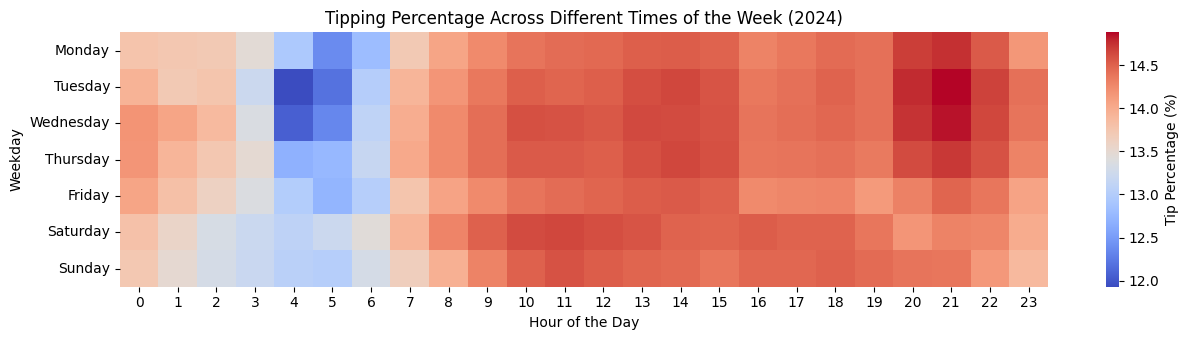

In [76]:
# Read required data from the database
tip_data = conn.sql("""
    select 
        pickup_datetime
        ,tip_amount
        ,total_amount
        ,payment_type
    from clean_yellow_trips
    where payment_type != 2  -- Exclude cash payments
    and p_year = 2024
""").df()

# Convert pickup_datetime to datetime
tip_data['pickup_datetime'] = pd.to_datetime(tip_data['pickup_datetime'])

# Extract weekday name and hour
tip_data['weekday'] = tip_data['pickup_datetime'].dt.day_name()
tip_data['hour'] = tip_data['pickup_datetime'].dt.hour

# Calculate tip percentage (avoid division by zero)
tip_data = tip_data[tip_data['total_amount'] > 0]
tip_data['tip_percent'] = (tip_data['tip_amount'] / tip_data['total_amount']) * 100

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tip_data['weekday'] = pd.Categorical(tip_data['weekday'], categories=weekday_order, ordered=True)

# Group and compute average tip percentage by weekday and hour
tip_percent = tip_data.groupby(['weekday', 'hour'], as_index=False)['tip_percent'].mean()

# Pivot for heatmap
tip_percent_heatmap = pd.pivot_table(tip_percent, values='tip_percent', index='weekday', columns='hour')

# Plot heatmap
fig, ax = plt.subplots(figsize=(13, 3.5))
sns.heatmap(tip_percent_heatmap, cbar_kws={'label': 'Tip Percentage (%)'}, ax=ax, cmap='coolwarm')
ax.set_ylabel('Weekday')
ax.set_xlabel('Hour of the Day')
ax.set_title('Tipping Percentage Across Different Times of the Week (2024)')
plt.tight_layout()
plt.show()

In [77]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

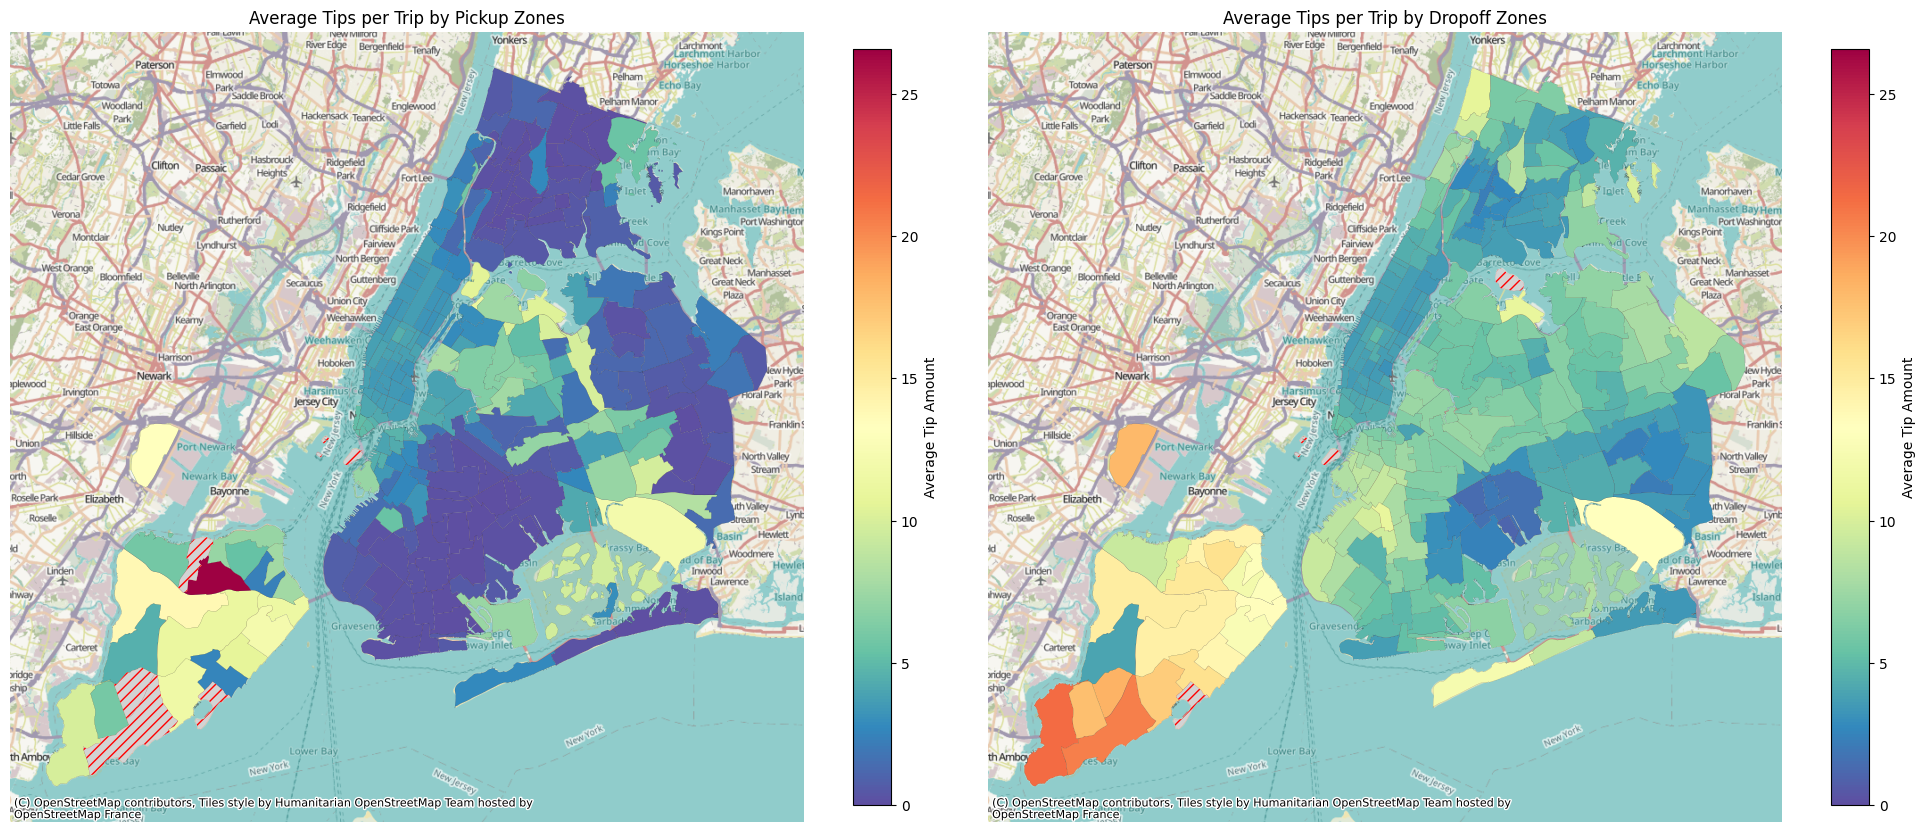

In [78]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx

sf = gpd.read_file('/kaggle/input/nyc-taxi-zone-shapefile/taxi_zones.shp')
tip_data = conn.sql("""
    SELECT 
        pickup_datetime,
        tip_amount,
        total_amount,
        payment_type,
        pickup_location_id,
        dropoff_location_id,
        p_year
    FROM clean_yellow_trips
    WHERE payment_type != 2  -- Exclude cash payments
    AND p_year = 2024
""").df()


def prepare_tip_gdf(tip_df, sf_gdf, location_col):
    """
    Merge tip averages with spatial dataframe (sf_gdf) for given location column (PULocationID or DOLocationID).
    Fill missing locations with NaN tip_amount and proper geometry.
    Convert CRS to EPSG:3857 for web mapping.
    """
    # Calculate average tip per location
    tip_avg = tip_df.groupby([location_col], as_index=False)['tip_amount'].mean()

    # Merge with spatial dataframe
    gdf = gpd.GeoDataFrame(pd.merge(tip_avg, sf_gdf, left_on=location_col, right_on='LocationID')).drop(location_col, axis=1)

    # Identify missing zones
    missing_ids = set(sf_gdf['OBJECTID']) - set(gdf['OBJECTID'])
    missing = sf_gdf[sf_gdf['OBJECTID'].isin(missing_ids)].copy()
    missing.insert(0, 'tip_amount', np.nan)
    missing = missing.drop('LocationID', axis=1)

    # Combine existing and missing
    gdf = pd.concat([gdf, missing]).reset_index(drop=True)
    gdf = gdf.rename({'OBJECTID': 'LocationID'}, axis=1)

    # Convert CRS for web mapping tiles
    gdf = gdf.to_crs(epsg=3857)
    return gdf

# Prepare GeoDataFrames for pickup and dropoff tip averages
pu_gdf = prepare_tip_gdf(tip_data, sf, 'pickup_location_id')
do_gdf = prepare_tip_gdf(tip_data, sf, 'dropoff_location_id')

# Plotting
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

# Define color scale limits for consistent color mapping
vmin, vmax = min(pu_gdf['tip_amount'].min(), do_gdf['tip_amount'].min()), max(pu_gdf['tip_amount'].max(), do_gdf['tip_amount'].max())

pu_gdf.plot(
    column='tip_amount', cmap='Spectral_r', linewidth=0.05, ax=axs[0], edgecolor='k',
    legend=True, legend_kwds={'label': "Average Tip Amount", 'shrink': 0.78},
    vmin=vmin, vmax=vmax,
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"}
)

do_gdf.plot(
    column='tip_amount', cmap='Spectral_r', linewidth=0.05, ax=axs[1], edgecolor='k',
    legend=True, legend_kwds={'label': "Average Tip Amount", 'shrink': 0.78},
    vmin=vmin, vmax=vmax,
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"}
)

# Add basemaps for context
ctx.add_basemap(axs[0])
ctx.add_basemap(axs[1])

# Clean up axes
for ax in axs:
    ax.set_axis_off()

axs[0].set_title("Average Tips per Trip by Pickup Zones")
axs[1].set_title("Average Tips per Trip by Dropoff Zones")

plt.tight_layout()
plt.show()

In [125]:
import plotly.express as px

# Ensure there are no duplicated columns before merging
do_gdf = do_gdf.loc[:, ~do_gdf.columns.duplicated()]

# Calculate dropoff location frequencies
dropoff_freq = tip_data['dropoff_location_id'].value_counts().rename_axis('LocationID').reset_index(name='dropoff_freq')

# Merge GeoDataFrame with frequency data on LocationID
top_10 = pd.merge(do_gdf, dropoff_freq, on='LocationID', how='inner')

# Filter zones with at least 100 dropoffs
top_10 = top_10[top_10['dropoff_freq'] > 100]

# Sort by average tip amount descending and select top 10 zones
top_10 = top_10.sort_values('tip_amount', ascending=False).head(10)

# Plot interactive bar chart using Plotly
fig = px.bar(
    top_10,
    x='zone',
    y='tip_amount',
    labels={'zone': 'Zone Name', 'tip_amount': 'Average Tips per Trip ($)'},
    title='Top 10 Zones with Highest Average Tips (Dropoff)',
    text='tip_amount'
)

fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    margin=dict(t=50, b=150),
    width=1000,    # width in pixels
    height=600     # height in pixels
)
fig.show(renderer='iframe')
fig.write_html("/kaggle/working/tip.html")

# passenger count

In [124]:
# Fetch yellow taxi passenger count data for 2024
yellow_df = conn.sql("""
    SELECT passenger_count
    FROM clean_yellow_trips
    WHERE p_year = 2024
""").df()

# Fetch green taxi passenger count data for 2024
green_df = conn.sql("""
    SELECT passenger_count
    FROM clean_green_trips
    WHERE p_year = 2024
""").df()

# Combine yellow and green dataframes
combined_df = pd.concat([yellow_df, green_df], ignore_index=True)

# Group by passenger count and calculate trip counts and percentages
passenger_stats = combined_df.groupby('passenger_count').size().reset_index(name='trip_count')
passenger_stats['trip_percentage'] = (passenger_stats['trip_count'] / passenger_stats['trip_count'].sum()) * 100
passenger_stats['formatted_percentage'] = passenger_stats['trip_percentage'].apply(lambda x: f"{x:.1f}%")

# Plot the combined bar chart
fig = px.bar(
    passenger_stats,
    x='passenger_count',
    y='trip_percentage',
    title='Taxi Trip Distribution by Passenger Count (2024)',
    text='formatted_percentage',
    color='passenger_count',
    color_discrete_sequence=px.colors.sequential.YlGnBu
)

fig.update_layout(
    xaxis_title='Number of Passengers',
    yaxis_title='Trip Percentage',
    xaxis_tickangle=-45,
    margin=dict(b=150),
    hovermode='x unified',
    width=1000,
    height=800,
    title_x=0.5
)

fig.update_traces(textposition='outside', texttemplate='%{text}')
fig.show(renderer='iframe')
fig.write_html("/kaggle/working/combined_passenger_count.html")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

---------------------------------------------------------------------------------------

بررسی مسیر های تاکسی سبز

میزان فعالیت در بازه های زمانی و فواصل خاص
برای پیدا کردن پر تردد ترین بازه ها

In [81]:
conn.sql("""
CREATE OR REPLACE VIEW green_time_distance_dist AS
SELECT
  year,
  FLOOR(trip_distance)::INTEGER AS distance_bucket,
  CASE
    WHEN EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 6  AND  9  THEN 'Morning'
    WHEN EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 10 AND 13 THEN 'Midday'
    WHEN EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
    WHEN EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
    ELSE 'Night'
  END AS time_of_day,
  COUNT(*) AS trip_count
FROM read_parquet(
    '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
    hive_partitioning=TRUE
)
WHERE
  LOWER(cap_type) = 'green'
  AND passenger_count = 1
  AND fare_amount > 0
  AND trip_distance > 0
  AND lpep_dropoff_datetime >= lpep_pickup_datetime
  AND EXTRACT(EPOCH FROM (lpep_dropoff_datetime - lpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
  AND FLOOR(trip_distance)::INTEGER BETWEEN 1 AND 9
GROUP BY year, distance_bucket, time_of_day;
""")

df_green = conn.sql("""
SELECT *
FROM (
  SELECT year, distance_bucket, time_of_day, trip_count
  FROM green_time_distance_dist
)
PIVOT (
  SUM(trip_count)
  FOR time_of_day IN ('Morning','Midday','Afternoon','Evening','Night')
)
ORDER BY year, distance_bucket;
""").df()

df_green

,year,distance_bucket,Morning,Midday,Afternoon,Evening,Night
0,2020,1,46296.0,65003.0,89185.0,78313.0,39589.0
1,2020,2,21676.0,33080.0,45687.0,38898.0,21238.0
2,2020,3,13136.0,18394.0,23511.0,20281.0,12614.0
3,2020,4,7597.0,10252.0,12250.0,11057.0,7772.0
4,2020,5,5507.0,7123.0,8536.0,7710.0,5874.0
5,2020,6,4677.0,5863.0,6265.0,5367.0,4240.0
6,2020,7,3435.0,4451.0,4705.0,3767.0,2981.0
7,2020,8,2097.0,2836.0,2952.0,2549.0,2144.0
8,2020,9,1477.0,1998.0,1995.0,1782.0,1470.0
9,2021,1,28721.0,38439.0,48759.0,34957.0,14899.0


پیدا کردن بازه ها و فواصل پر تردد

In [82]:
# استخراج توزیع زمانی سفرهای تاکسی سبز (فاصله 1 تا 5 مایل)
green_df_time_all = conn.sql("""
SELECT
  time_of_day,
  SUM(trip_count) AS trip_count
FROM green_time_distance_dist
WHERE distance_bucket BETWEEN 1 AND 5
  AND year BETWEEN 2023 AND 2025
GROUP BY time_of_day
""").df()

# مرتب‌سازی بازه‌های زمانی
time_order = ['Morning', 'Midday', 'Afternoon', 'Evening', 'Night']
green_df_time_all['time_of_day'] = pd.Categorical(green_df_time_all['time_of_day'], categories=time_order, ordered=True)
green_df_time_all = green_df_time_all.sort_values('time_of_day')

# استخراج توزیع سفرهای سبز (فقط Afternoon و Evening، فاصله 1 تا 9 مایل)
green_df_dist_ae = conn.sql("""
SELECT
  distance_bucket,
  SUM(trip_count) AS trip_count
FROM green_time_distance_dist
WHERE distance_bucket BETWEEN 1 AND 9
  AND time_of_day IN ('Afternoon', 'Evening')
  AND year BETWEEN 2023 AND 2025
GROUP BY distance_bucket
ORDER BY distance_bucket
""").df()

import plotly.express as px

fig1 = px.bar(
    green_df_time_all,
    x='time_of_day',
    y='trip_count',
    title='Green Taxi – Trip Distribution by Time of Day (1–5 Miles, 2023–2025)',
    labels={'time_of_day': 'Time of Day', 'trip_count': 'Trip Count'},
    color_discrete_sequence=['darkslategray']
)
fig1.update_layout(
    template='simple_white',
    yaxis=dict(showgrid=True, gridcolor='lightgrey', gridwidth=0.5),
    xaxis=dict(showgrid=False)
)

fig2 = px.bar(
    green_df_dist_ae,
    x='distance_bucket',
    y='trip_count',
    title='Green Taxi – Trip Distribution by Distance Bucket (Afternoon & Evening, 1–9 Miles)',
    labels={'distance_bucket': 'Distance Bucket (Miles)', 'trip_count': 'Trip Count'},
    color_discrete_sequence=['darkslategray']
)
fig2.update_layout(
    template='simple_white',
    yaxis=dict(showgrid=True, gridcolor='lightgrey', gridwidth=0.5),
    xaxis=dict(showgrid=False)
)

fig1.show(renderer='iframe')

In [83]:
fig2.show(renderer='iframe')

یافتن پر تقاضا ترین مسیر های سبز در بازه ۱ تا ۳ مایل
در دو سال پایانی
در بازه های زمانی پر تردد

In [84]:
df_top10_per_mile_time_green = conn.sql("""
WITH filtered AS (
    SELECT
        FLOOR(trip_distance)::INTEGER        AS distance_bucket,
        PULocationID                         AS from_zone,
        DOLocationID                         AS to_zone,
        CASE
            WHEN EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
            WHEN EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
        END AS time_of_day,
        total_amount,
        DATE_TRUNC('day', lpep_pickup_datetime) AS trip_date
    FROM read_parquet(
        '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
        hive_partitioning=TRUE
    )
    WHERE
        lower(cap_type) = 'green'
        AND year IN (2023, 2024, 2025)
        AND FLOOR(trip_distance)::INTEGER BETWEEN 1 AND 3
        AND EXTRACT(HOUR FROM lpep_pickup_datetime) BETWEEN 14 AND 21
        AND EXTRACT(EPOCH FROM (lpep_dropoff_datetime - lpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
        AND passenger_count IN (1, 2)
),
agg AS (
    SELECT
        time_of_day,
        distance_bucket,
        from_zone,
        to_zone,
        COUNT(*)                           AS total_trips,
        ROUND(AVG(total_amount), 2)       AS avg_trip_price,
        COUNT(DISTINCT trip_date)         AS active_days,
        ROUND(COUNT(*)::DOUBLE / COUNT(DISTINCT trip_date), 2) AS avg_daily_trips
    FROM filtered
    WHERE time_of_day IS NOT NULL
    GROUP BY time_of_day, distance_bucket, from_zone, to_zone
),
ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY time_of_day, distance_bucket
            ORDER BY total_trips DESC
        ) AS rn
    FROM agg
)
SELECT
    time_of_day,
    distance_bucket,
    from_zone,
    to_zone,
    total_trips,
    avg_trip_price,
    avg_daily_trips
FROM ranked
WHERE rn <= 10
ORDER BY time_of_day, distance_bucket, total_trips DESC;
""").df()

df_top10_per_mile_time_green

,time_of_day,distance_bucket,from_zone,to_zone,total_trips,avg_trip_price,avg_daily_trips
0,Afternoon,1,75,74,13023,14.02,17.34
1,Afternoon,1,74,75,6558,14.67,8.62
2,Afternoon,1,74,236,4320,19.77,5.68
3,Afternoon,1,74,166,3470,17.71,4.64
4,Afternoon,1,74,41,2846,14.06,3.85
5,Afternoon,1,75,238,2834,17.53,4.19
6,Afternoon,1,95,95,2574,15.12,3.59
7,Afternoon,1,75,263,2408,18.71,3.58
8,Afternoon,1,75,41,2390,14.46,3.42
9,Afternoon,1,75,236,2346,17.98,3.56


با تحلیل ۱۰ مسیر پرتردد برای هر بازه زمانی و فاصله ۱ تا ۳ مایل میانگین سفر های روزانه در تمامی دسته ها کمتر از ۶ است

این عدد از ظرفیت کامل یک ون هم کمتر است یعنی حتی در بهینه ترین مسیر تقاضای روزانه برای یک بازه زمانی به حدی نیست که برای راه اندازی سرویس ون اشتراکی مناسب باشد

In [123]:
import plotly.express as px
import pandas as pd

grouped = (
    df_top10_per_mile_time_green
    .groupby(['time_of_day', 'distance_bucket'])['avg_daily_trips']
    .mean()
    .reset_index()
)

grouped['label'] = grouped['time_of_day'] + ' | ' + grouped['distance_bucket'].astype(str) + ' mi'
order = ['Afternoon | 1 mi', 'Afternoon | 2 mi', 'Afternoon | 3 mi',
         'Evening | 1 mi', 'Evening | 2 mi', 'Evening | 3 mi']
grouped['label'] = pd.Categorical(grouped['label'], categories=order, ordered=True)
grouped = grouped.sort_values('label')

fig = px.bar(
    grouped,
    x='label',
    y='avg_daily_trips',
    title=" Average Daily Trips in Top 10 Routes by Distance & Time of Day",
    labels={
        'label': 'Time of Day | Trip Distance (Miles)',
        'avg_daily_trips': 'Avg Daily Trips'
    },
    color_discrete_sequence=['darkolivegreen']
)

fig.update_layout(
    template='simple_white',
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        griddash='dash',
        title='Avg Daily Trips (Mean of Top 10 Routes)'
    ),
    xaxis=dict(
        showgrid=False,
        gridcolor='lightgray',
        griddash='dash',
        title='Time of Day | Trip Distance (Miles)'
    )
)

fig.show(renderer='iframe')

انتخاب بازه زمانی و مسافتی برای تاکسی های زرد

میزان فعالیت در بازه های زمانی و فواصل خاص
برای پیدا کردن پر تردد ترین بازه ها


In [86]:
conn.sql("""
CREATE OR REPLACE VIEW yellow_time_distance_dist AS
SELECT
  year,
  FLOOR(trip_distance)::INTEGER AS distance_bucket,
  CASE
    WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 6  AND  9  THEN 'Morning'
    WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 10 AND 13 THEN 'Midday'
    WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
    WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
    ELSE 'Night'
  END AS time_of_day,
  COUNT(*) AS trip_count
FROM read_parquet(
    '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
    hive_partitioning=TRUE
)
WHERE
  LOWER(cap_type) = 'yellow'
  AND passenger_count = 1
  AND fare_amount > 0
  AND trip_distance > 0
  AND tpep_dropoff_datetime >= tpep_pickup_datetime
  AND EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
  AND FLOOR(trip_distance)::INTEGER BETWEEN 1 AND 9
GROUP BY year, distance_bucket, time_of_day;
""")

df = conn.sql("""
SELECT *
FROM (
  SELECT year, distance_bucket, time_of_day, trip_count
  FROM yellow_time_distance_dist
) 
PIVOT (
  SUM(trip_count) 
  FOR time_of_day IN ('Morning','Midday','Afternoon','Evening','Night')
)
ORDER BY year, distance_bucket;
""").df()

df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,year,distance_bucket,Morning,Midday,Afternoon,Evening,Night
0,2020,1,1009563.0,1407234.0,1573473.0,1312544.0,675747.0
1,2020,2,467914.0,606540.0,699583.0,654678.0,374597.0
2,2020,3,202607.0,259876.0,308888.0,316843.0,225471.0
3,2020,4,94705.0,124829.0,151748.0,166924.0,146915.0
4,2020,5,59633.0,78107.0,92681.0,103147.0,99704.0
5,2020,6,43187.0,54146.0,62885.0,71610.0,71054.0
6,2020,7,32021.0,40963.0,48874.0,55891.0,53855.0
7,2020,8,25545.0,35584.0,43356.0,45829.0,42670.0
8,2020,9,20389.0,33296.0,40183.0,35896.0,34789.0
9,2021,1,1029258.0,1787487.0,2053691.0,1664530.0,784234.0


پیدا کردن بازه ها و فواصل پر تردد

In [121]:
yellow_df_time_all = conn.sql("""
SELECT
  time_of_day,
  SUM(trip_count) AS trip_count
FROM yellow_time_distance_dist
WHERE distance_bucket BETWEEN 1 AND 5
  AND year BETWEEN 2023 AND 2025
GROUP BY time_of_day
""").df()

time_order = ['Morning', 'Midday', 'Afternoon', 'Evening', 'Night']
yellow_df_time_all['time_of_day'] = pd.Categorical(yellow_df_time_all['time_of_day'], categories=time_order, ordered=True)
yellow_df_time_all = yellow_df_time_all.sort_values('time_of_day')

yellow_df_dist_ae = conn.sql("""
SELECT
  distance_bucket,
  SUM(trip_count) AS trip_count
FROM yellow_time_distance_dist
WHERE distance_bucket BETWEEN 1 AND 9
  AND time_of_day IN ('Afternoon', 'Evening')
  AND year BETWEEN 2023 AND 2025
GROUP BY distance_bucket
ORDER BY distance_bucket
""").df()

import plotly.express as px

yellow_fig1 = px.bar(
    yellow_df_time_all,
    x='time_of_day',
    y='trip_count',
    title='Trip Distribution by Time of Day (Yellow Taxi, 1–5 Miles, 2023–2025)',
    labels={
        'time_of_day': 'Time of Day',
        'trip_count': 'Trip Count'
    },
    color_discrete_sequence=['goldenrod']
)
yellow_fig1.update_layout(
    template='simple_white',
    yaxis=dict(showgrid=True, gridcolor='lightgray', griddash='dash'),
    xaxis=dict(showgrid=False)
)

yellow_fig2 = px.bar(
    yellow_df_dist_ae,
    x='distance_bucket',
    y='trip_count',
    title='Trip Distribution by Distance Bucket (Afternoon & Evening, Yellow Taxi, 1–9 Miles)',
    labels={
        'distance_bucket': 'Distance Bucket (Miles)',
        'trip_count': 'Trip Count'
    },
    color_discrete_sequence=['goldenrod']
)
yellow_fig2.update_layout(
    template='simple_white',
    yaxis=dict(showgrid=True, gridcolor='lightgray', griddash='dash'),
    xaxis=dict(showgrid=False)
)

yellow_fig1.show(renderer='iframe')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [122]:
yellow_fig2.show(renderer='iframe')

یافتن پر تقاضا ترین مسیر های زرد در بازه ۱ تا ۵ مایل
یک یا دو مسافر

در سه سال پایانی
انتخاب چهار مسیر پر تردد

In [89]:
import pandas as pd

df_top4_per_mile = conn.sql("""
WITH filtered AS (
    SELECT
        FLOOR(trip_distance)::INTEGER        AS distance_bucket,
        PULocationID                         AS from_zone,
        DOLocationID                         AS to_zone,
        CASE
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
        END AS time_of_day,
        total_amount,
        DATE_TRUNC('day', tpep_pickup_datetime) AS trip_date
    FROM read_parquet(
        '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
        hive_partitioning=TRUE
    )
    WHERE
        lower(cap_type) = 'yellow'
        AND year IN (2023, 2024, 2025)
        AND FLOOR(trip_distance)::INTEGER BETWEEN 1 AND 5
        AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 21
        AND EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
        AND passenger_count IN (1, 2)
),
agg AS (
    SELECT
        time_of_day,
        distance_bucket,
        from_zone,
        to_zone,
        COUNT(*)                           AS total_trips,
        ROUND(AVG(total_amount), 2)       AS avg_trip_price,
        COUNT(DISTINCT trip_date)         AS active_days,
        ROUND(COUNT(*)::DOUBLE / COUNT(DISTINCT trip_date), 2) AS avg_daily_trips
    FROM filtered
    WHERE time_of_day IS NOT NULL
    GROUP BY time_of_day, distance_bucket, from_zone, to_zone
),
ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY time_of_day, distance_bucket
            ORDER BY total_trips DESC
        ) AS rn
    FROM agg
)
SELECT
    time_of_day,
    distance_bucket,
    from_zone,
    to_zone,
    total_trips,
    avg_trip_price,
    avg_daily_trips
FROM ranked
WHERE rn <= 4
ORDER BY time_of_day, distance_bucket, total_trips DESC;
""").df()

df_top4_per_mile

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,time_of_day,distance_bucket,from_zone,to_zone,total_trips,avg_trip_price,avg_daily_trips
0,Afternoon,1,237,236,91543,17.85,120.77
1,Afternoon,1,236,237,67059,18.55,88.47
2,Afternoon,1,161,237,45717,19.66,60.31
3,Afternoon,1,161,236,38688,21.41,51.04
4,Afternoon,2,161,236,24937,25.65,32.90
5,Afternoon,2,142,236,18284,23.52,24.12
6,Afternoon,2,236,142,16182,24.33,21.35
7,Afternoon,2,237,238,16174,25.28,21.34
8,Afternoon,3,186,236,7968,35.68,10.53
9,Afternoon,3,234,236,6939,34.28,9.17


تحلیل حجم تقاضا براساس فاصله سفر
بصری سازی رابطه ای بین فاصله سفر و تعداد سفر های روزانه
و توجیح اینکه چرا ون اشتراکی باید روی مسیر کوتاه ۱ تا ۳ مایل تمرکز کنه
- مسیر های بالای ۳ مایل به رغم قیمت بالاتر به دلیل تقاضای پایین برای مدل ون اشتراکی به صرفه نیستند

In [120]:
import plotly.express as px

grouped = (
    df_top4_per_mile
    .groupby(['time_of_day', 'distance_bucket'])['avg_daily_trips']
    .mean()
    .reset_index()
)

grouped['label'] = grouped['time_of_day'] + ' | ' + grouped['distance_bucket'].astype(str) + ' mi'

order = [f'Afternoon | {i} mi' for i in range(1, 6)] + [f'Evening | {i} mi' for i in range(1, 6)]
grouped['label'] = pd.Categorical(grouped['label'], categories=order, ordered=True)
grouped = grouped.sort_values('label')

fig = px.bar(
    grouped,
    x='label',
    y='avg_daily_trips',
    title="Average Daily Trips in Top 4 Yellow Taxi Routes (1–5 Miles)",
    labels={
        'label': 'Time of Day | Trip Distance (Miles)',
        'avg_daily_trips': 'Average Daily Trips'
    },
    text=grouped['avg_daily_trips'].round(1),
    color_discrete_sequence=['goldenrod']
)

fig.update_layout(
    template='simple_white',
    xaxis_tickangle=-45,
    yaxis=dict(showgrid=True, gridcolor='lightgray', griddash='dash'),
    xaxis=dict(showgrid=False),
    uniformtext_minsize=10,
    uniformtext_mode='hide'
)

fig.show(renderer='iframe')

فیلتر مسیر ها برای اجرای عملیاتی ون
- فیلتر میانگین سفر: اگر تقاضا کمتر از ۹ سفر در روز باشه ون در مسیر خالی میمونه و پر نمیشه و سود آور نیست
- فیلتر میانگین قیمت: مسیر هایی با کمتر از ۱۸ دلار ارزش برای راننده و ناوگان ندارد همچنین میزان تخفیف برای کاستومر هم قابل توجه نیست


In [91]:
df_top10_per_mile_time = conn.sql("""
WITH filtered AS (
    SELECT
        FLOOR(trip_distance)::INTEGER        AS distance_bucket,
        PULocationID                         AS from_zone,
        DOLocationID                         AS to_zone,
        CASE
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
        END AS time_of_day,
        total_amount,
        DATE_TRUNC('day', tpep_pickup_datetime) AS trip_date,
        EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 AS trip_duration_minutes
    FROM read_parquet(
        '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
        hive_partitioning=TRUE
    )
    WHERE
        lower(cap_type) = 'yellow'
        AND year IN (2024, 2025)
        AND FLOOR(trip_distance)::INTEGER BETWEEN 1 AND 3
        AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 21
        AND EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
        AND passenger_count IN (1, 2)
),
agg AS (
    SELECT
        time_of_day,
        distance_bucket,
        from_zone,
        to_zone,
        COUNT(*)                           AS total_trips,
        ROUND(AVG(total_amount), 2)       AS avg_trip_price,
        ROUND(AVG(trip_duration_minutes), 2) AS avg_trip_time_minutes,
        COUNT(DISTINCT trip_date)         AS active_days,
        ROUND(COUNT(*)::DOUBLE / COUNT(DISTINCT trip_date), 2) AS avg_daily_trips
    FROM filtered
    WHERE time_of_day IS NOT NULL
    GROUP BY time_of_day, distance_bucket, from_zone, to_zone
),
ranked AS (
    SELECT
        *,
        ROW_NUMBER() OVER (
            PARTITION BY time_of_day, distance_bucket
            ORDER BY total_trips DESC
        ) AS rn
    FROM agg
)
SELECT
    time_of_day,
    distance_bucket,
    from_zone,
    to_zone,
    total_trips,
    avg_trip_price,
    avg_trip_time_minutes,
    avg_daily_trips
FROM ranked
WHERE rn <= 10
  AND avg_daily_trips >= 9
  AND avg_trip_price >= 18
ORDER BY time_of_day, distance_bucket, total_trips DESC;
""").df()
df_top10_per_mile_time

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,time_of_day,distance_bucket,from_zone,to_zone,total_trips,avg_trip_price,avg_trip_time_minutes,avg_daily_trips
0,Afternoon,1,236,237,35276,18.49,10.63,88.86
1,Afternoon,1,161,237,24236,19.63,12.37,61.05
2,Afternoon,1,161,236,21378,21.38,13.81,53.85
3,Afternoon,1,236,239,20631,18.52,10.23,51.97
4,Afternoon,1,236,238,20514,18.43,10.16,51.67
5,Afternoon,1,161,234,19727,20.13,12.73,49.69
6,Afternoon,1,237,142,19215,19.38,11.99,48.40
7,Afternoon,1,140,236,17423,18.57,10.85,44.00
8,Afternoon,2,161,236,12679,25.59,17.95,31.94
9,Afternoon,2,142,236,9683,23.66,15.07,24.39


کد پیدا کردن اطلاعات سفر انتخابی

In [92]:
df_route = conn.sql("""
WITH filtered AS (
    SELECT
        FLOOR(trip_distance)::INTEGER        AS distance_bucket,
        trip_distance,
        PULocationID                         AS from_zone,
        DOLocationID                         AS to_zone,
        CASE
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
        END AS time_of_day,
        total_amount,
        DATE_TRUNC('day', tpep_pickup_datetime) AS trip_date,
        EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 AS trip_duration_minutes
    FROM read_parquet(
        '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
        hive_partitioning=TRUE
    )
    WHERE
        lower(cap_type) = 'yellow'
        AND year IN (2025)
        AND PULocationID = 142
        AND DOLocationID = 236
        AND FLOOR(trip_distance)::INTEGER BETWEEN 1 AND 3
        AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 21
        AND EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
        AND passenger_count IN (1, 2)
),
agg AS (
    SELECT
        time_of_day,
        distance_bucket,
        ROUND(AVG(trip_distance), 2)         AS avg_trip_distance,
        ROUND(AVG(total_amount), 2)          AS avg_trip_price,
        ROUND(AVG(trip_duration_minutes), 2) AS avg_trip_time_minutes,
        COUNT(*)                             AS total_trips,
        COUNT(DISTINCT trip_date)            AS active_days,
        ROUND(COUNT(*)::DOUBLE / COUNT(DISTINCT trip_date), 2) AS avg_daily_trips
    FROM filtered
    WHERE time_of_day IS NOT NULL
    GROUP BY time_of_day, distance_bucket
)
SELECT *
FROM agg
ORDER BY time_of_day, distance_bucket;
""").df()

df_route

,time_of_day,distance_bucket,avg_trip_distance,avg_trip_price,avg_trip_time_minutes,total_trips,active_days,avg_daily_trips
0,Afternoon,1,1.71,19.21,10.82,700,31,22.58
1,Afternoon,2,2.31,23.66,14.66,844,31,27.23
2,Afternoon,3,3.16,29.35,20.06,33,19,1.74
3,Evening,1,1.72,18.79,9.18,709,31,22.87
4,Evening,2,2.32,21.90,12.08,1175,31,37.90
5,Evening,3,3.15,27.25,16.99,34,20,1.70


اطلاعات تمامی مسیر های برگزیده

In [93]:
df_all_route = conn.sql("""
WITH filtered AS (
    SELECT
        FLOOR(trip_distance)::INTEGER        AS distance_bucket,
        trip_distance,
        PULocationID                         AS from_zone,
        DOLocationID                         AS to_zone,
        CASE
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17 THEN 'Afternoon'
            WHEN EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21 THEN 'Evening'
        END AS time_of_day,
        total_amount,
        DATE_TRUNC('day', tpep_pickup_datetime) AS trip_date,
        EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 AS trip_duration_minutes
    FROM read_parquet(
        '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
        hive_partitioning=TRUE
    )
    WHERE
        lower(cap_type) = 'yellow'
        AND year IN (2025,2024)
        AND (
            (PULocationID = 161 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 236 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 237 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 236 AND DOLocationID = 239 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 239 AND DOLocationID = 161 AND FLOOR(trip_distance) = 2 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 237 AND DOLocationID = 161 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 161 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 237 AND DOLocationID = 142 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 142 AND DOLocationID = 236 AND FLOOR(trip_distance) = 2 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17)
            OR
            (PULocationID = 161 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
            OR
            (PULocationID = 236 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
            OR
            (PULocationID = 237 AND DOLocationID = 142 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
            OR
            (PULocationID = 142 AND DOLocationID = 236 AND FLOOR(trip_distance) = 2 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
            OR
            (PULocationID = 236 AND DOLocationID = 161 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
            OR
            (PULocationID = 170 AND DOLocationID = 236 AND FLOOR(trip_distance) = 2 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
            OR
            (PULocationID = 237 AND DOLocationID = 170 AND FLOOR(trip_distance) = 1 AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21)
        )
        AND EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
        AND passenger_count IN (1, 2)
),
agg AS (
    SELECT
        time_of_day,
        from_zone,
        to_zone,
        distance_bucket,
        ROUND(AVG(trip_distance), 2)         AS avg_trip_distance,
        ROUND(AVG(total_amount), 2)          AS avg_trip_price,
        ROUND(AVG(trip_duration_minutes), 2) AS avg_trip_time_minutes,
        COUNT(*)                             AS total_trips,
        COUNT(DISTINCT trip_date)            AS active_days,
        ROUND(COUNT(*)::DOUBLE / COUNT(DISTINCT trip_date), 2) AS avg_daily_trips
    FROM filtered
    WHERE time_of_day IS NOT NULL
    GROUP BY time_of_day, from_zone, to_zone, distance_bucket
)
SELECT *
FROM agg
ORDER BY time_of_day, from_zone, to_zone;
""").df()

df_all_route

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,time_of_day,from_zone,to_zone,distance_bucket,avg_trip_distance,avg_trip_price,avg_trip_time_minutes,total_trips,active_days,avg_daily_trips
0,Afternoon,142,236,2,2.32,23.66,15.07,9683,397,24.39
1,Afternoon,161,236,1,1.64,21.38,13.81,21378,397,53.85
2,Afternoon,161,237,1,1.29,19.63,12.37,24236,397,61.05
3,Afternoon,236,237,1,1.28,18.49,10.63,35276,397,88.86
4,Afternoon,236,239,1,1.43,18.52,10.23,20631,397,51.97
5,Afternoon,237,142,1,1.33,19.38,11.99,19215,397,48.40
6,Afternoon,237,161,1,1.28,20.65,13.98,14531,397,36.60
7,Afternoon,237,236,1,1.30,17.79,9.70,49238,397,124.03
8,Afternoon,239,161,2,2.34,26.38,19.70,4777,396,12.06
9,Evening,142,236,2,2.34,22.27,12.29,12182,397,30.69


بررسی تقاضای مسیر اول

تقاضای بیشتر روی سه شنبه تا پنج شنبه 
تقاضای کمتر در شنبه و یکشنبه

In [94]:
conn.sql("""
WITH daily_trip_counts AS (
  SELECT
    STRFTIME(tpep_pickup_datetime, '%A') AS weekday,
    CAST(tpep_pickup_datetime AS DATE) AS trip_date,
    COUNT(*) AS trip_count
  FROM read_parquet(
    '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
    hive_partitioning=TRUE
  )
  WHERE
    lower(cap_type) = 'yellow'
    AND year IN (2024, 2025)
    AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17
    AND (
      (PULocationID = 161 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 236 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 237 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 236 AND DOLocationID = 239 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 239 AND DOLocationID = 161 AND FLOOR(trip_distance) = 2)
    )
  GROUP BY weekday, trip_date
)

SELECT
  weekday,
  SUM(trip_count) AS total_trips,
  MEDIAN(trip_count) AS median_trips,
  STDDEV_POP(trip_count) AS std_trips
FROM daily_trip_counts
GROUP BY weekday
ORDER BY 
  CASE weekday
    WHEN 'Monday' THEN 1
    WHEN 'Tuesday' THEN 2
    WHEN 'Wednesday' THEN 3
    WHEN 'Thursday' THEN 4
    WHEN 'Friday' THEN 5
    WHEN 'Saturday' THEN 6
    WHEN 'Sunday' THEN 7
  END;
  """).df()


,weekday,total_trips,median_trips,std_trips
0,Monday,21322.0,392.0,91.950570
1,Tuesday,24908.0,448.0,86.930804
2,Wednesday,24687.0,446.0,96.484465
3,Thursday,25156.0,461.0,104.835265
4,Friday,22109.0,404.0,99.834964
5,Saturday,16353.0,293.5,82.273388
6,Sunday,13106.0,233.5,66.133513


بررسی تقاضای مسیر دوم

روزهای مطلوب دوشنبه تا پنج شنبه 
شنبه و یکشنبه حجم سفر کمی دارند

In [95]:
conn.sql("""
WITH daily_trip_counts AS (
  SELECT
    STRFTIME(tpep_pickup_datetime, '%A') AS weekday,
    CAST(tpep_pickup_datetime AS DATE) AS trip_date,
    COUNT(*) AS trip_count
  FROM read_parquet(
    '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
    hive_partitioning=TRUE
  )
  WHERE
    lower(cap_type) = 'yellow'
    AND year IN (2024, 2025)
    AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17
    AND (
      (PULocationID = 236 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 237 AND DOLocationID = 161 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 161 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 237 AND DOLocationID = 142 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 142 AND DOLocationID = 236 AND FLOOR(trip_distance) = 2)
    )
  GROUP BY weekday, trip_date
)

SELECT
  weekday,
  SUM(trip_count) AS total_trips,
  MEDIAN(trip_count) AS median_trips,
  STDDEV_POP(trip_count) AS std_trips
FROM daily_trip_counts
GROUP BY weekday
ORDER BY 
  CASE weekday
    WHEN 'Monday' THEN 1
    WHEN 'Tuesday' THEN 2
    WHEN 'Wednesday' THEN 3
    WHEN 'Thursday' THEN 4
    WHEN 'Friday' THEN 5
    WHEN 'Saturday' THEN 6
    WHEN 'Sunday' THEN 7
  END;
  """).df()


,weekday,total_trips,median_trips,std_trips
0,Monday,16257.0,299.0,60.810530
1,Tuesday,19317.0,353.0,59.364082
2,Wednesday,19711.0,358.0,70.642276
3,Thursday,19784.0,360.0,77.687245
4,Friday,16741.0,300.0,67.072876
5,Saturday,13606.0,245.0,65.468358
6,Sunday,10681.0,180.0,54.864278


بررسی مسیر سوم

چهارشنبه و پنج شنبه پر تردد ترین روز های مسیر 
شنبه و یکشنبه کم تردد و یکنواخت

In [96]:
conn.sql("""
WITH daily_trip_counts AS (
  SELECT
    STRFTIME(tpep_pickup_datetime, '%A') AS weekday,
    CAST(tpep_pickup_datetime AS DATE) AS trip_date,
    COUNT(*) AS trip_count
  FROM read_parquet(
    '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
    hive_partitioning=TRUE
  )
  WHERE
    lower(cap_type) = 'yellow'
    AND year IN (2024, 2025)
    AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21
    AND (
      (PULocationID = 161 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 236 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 237 AND DOLocationID = 142 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 142 AND DOLocationID = 236 AND FLOOR(trip_distance) = 2) OR
      (PULocationID = 236 AND DOLocationID = 161 AND FLOOR(trip_distance) = 1)
    )
  GROUP BY weekday, trip_date
)

SELECT
  weekday,
  SUM(trip_count) AS total_trips,
  MEDIAN(trip_count) AS median_trips,
  STDDEV_POP(trip_count) AS std_trips
FROM daily_trip_counts
GROUP BY weekday
ORDER BY 
  CASE weekday
    WHEN 'Monday' THEN 1
    WHEN 'Tuesday' THEN 2
    WHEN 'Wednesday' THEN 3
    WHEN 'Thursday' THEN 4
    WHEN 'Friday' THEN 5
    WHEN 'Saturday' THEN 6
    WHEN 'Sunday' THEN 7
  END;
  """).df()


,weekday,total_trips,median_trips,std_trips
0,Monday,11061.0,212.0,58.976778
1,Tuesday,15163.0,271.0,71.321730
2,Wednesday,15532.0,284.0,73.128611
3,Thursday,15425.0,287.0,87.939324
4,Friday,11478.0,209.0,63.734271
5,Saturday,9867.0,175.5,54.802053
6,Sunday,5978.0,107.0,31.274847


بررسی مسیر چهارم

پر تردد ترین روز چهارشنبه و پنج شنبه 
شنبه و یکشنبه افت زیاد

In [97]:
conn.sql("""
WITH daily_trip_counts AS (
  SELECT
    STRFTIME(tpep_pickup_datetime, '%A') AS weekday,
    CAST(tpep_pickup_datetime AS DATE) AS trip_date,
    COUNT(*) AS trip_count
  FROM read_parquet(
    '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
    hive_partitioning=TRUE
  )
  WHERE
    lower(cap_type) = 'yellow'
    AND year IN (2024, 2025)
    AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 18 AND 21
    AND (
      (PULocationID = 170 AND DOLocationID = 236 AND FLOOR(trip_distance) = 2) OR
      (PULocationID = 236 AND DOLocationID = 161 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 161 AND DOLocationID = 236 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 236 AND DOLocationID = 237 AND FLOOR(trip_distance) = 1) OR
      (PULocationID = 237 AND DOLocationID = 170 AND FLOOR(trip_distance) = 1)
    )
  GROUP BY weekday, trip_date
)

SELECT
  weekday,
  SUM(trip_count) AS total_trips,
  MEDIAN(trip_count) AS median_trips,
  STDDEV_POP(trip_count) AS std_trips
FROM daily_trip_counts
GROUP BY weekday
ORDER BY 
  CASE weekday
    WHEN 'Monday' THEN 1
    WHEN 'Tuesday' THEN 2
    WHEN 'Wednesday' THEN 3
    WHEN 'Thursday' THEN 4
    WHEN 'Friday' THEN 5
    WHEN 'Saturday' THEN 6
    WHEN 'Sunday' THEN 7
  END;
  """).df()


,weekday,total_trips,median_trips,std_trips
0,Monday,9806.0,180.0,54.532773
1,Tuesday,12705.0,221.0,54.696510
2,Wednesday,12991.0,240.0,62.191634
3,Thursday,12469.0,233.0,68.530255
4,Friday,9273.0,169.0,47.973003
5,Saturday,7414.0,136.0,37.687947
6,Sunday,4594.0,83.5,24.267088


چرا برای تعیین میزان تخفیف به منابع خارج از دیتا نیاز داریم

تحلیل های رگرسیونی انجام شده در دو سطح متفاوت یکی روی کل داده های تاکسی های زرد و دیگری روی یک مسیر خاص در بازه بعد از ظهر نشان دادند که تعداد مسافر تاثیر معناداری بر قیمت سفر ندارد 

In [98]:
import statsmodels.api as sm
import pandas as pd

df_raw = conn.sql("""
    SELECT
        fare_amount,
        passenger_count
    FROM read_parquet(
        '/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet',
        hive_partitioning=TRUE
    )
    WHERE
        lower(cap_type) = 'yellow'
        AND year IN (2023, 2024, 2025)
        AND fare_amount > 0
        AND passenger_count BETWEEN 1 AND 6
""").df()

df_reg = df_raw[["fare_amount", "passenger_count"]].copy()

df_reg = df_reg[(df_reg["fare_amount"] > 2) & (df_reg["fare_amount"] < 200)]

y = df_reg["fare_amount"]
X = df_reg[["passenger_count"]]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                 1.979e+05
Date:                Thu, 18 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:46:35   Log-Likelihood:            -3.2134e+08
No. Observations:            74897724   AIC:                         6.427e+08
Df Residuals:                74897722   BIC:                         6.427e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              18.2297      0.004   46

ضریب تعداد مسافر= : ۱.۰۸ دلار
R-squared: 0.003 / فقط ۰.۳ درصد از تغییرات کرایه توسط تعداد مسافر توضیح داده شده
P-value / از نظر آماری معنادار
اگرچه اثر آماری معناداره ولی شدت اثر خیلی پایینه
ایراد این مدل اینه که در شرایط یکسانی نبوده است

In [99]:
import statsmodels.api as sm
import pandas as pd

df_filtered = conn.sql("""
    SELECT
        fare_amount,
        passenger_count,
        trip_distance
    FROM read_parquet('/kaggle/input/tlc-trip-record-data-2020-2025/trips/**/*.parquet', hive_partitioning=TRUE)
    WHERE
        lower(cap_type) = 'yellow'
        AND year IN (2023, 2024, 2025)
        AND PULocationID = 237
        AND DOLocationID = 236
        AND EXTRACT(HOUR FROM tpep_pickup_datetime) BETWEEN 14 AND 17  -- Afternoon
        AND EXTRACT(EPOCH FROM (tpep_dropoff_datetime - tpep_pickup_datetime)) / 60 BETWEEN 1 AND 120
        AND fare_amount > 0
        AND trip_distance BETWEEN 1.5 AND 2.5
        AND passenger_count BETWEEN 1 AND 6
""").df()

df_filtered = df_filtered[(df_filtered["fare_amount"] > 2) & (df_filtered["fare_amount"] < 200)]

y = df_filtered["fare_amount"]
X = df_filtered[["passenger_count"]]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7732
Date:                Thu, 18 Sep 2025   Prob (F-statistic):              0.379
Time:                        16:46:41   Log-Likelihood:                -56991.
No. Observations:               23514   AIC:                         1.140e+05
Df Residuals:                   23512   BIC:                         1.140e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.8619      0.033    3

در شرایط کنترل شده: اثر تعداد مسافر در مسیر پر تردد
afternoon 237-236

ضریب تعداد مسافر: -0.019 دلار
R-squared: 0.000 / هیچ بخشی از تغییرات کرایه توسط تعداد مسافر توضیح داده نشده
P-value / از نظر آماری کاملا غیر معنا دار

در شرایط کنترل شده مشخص شد تعداد مسافر تاثیر آماری معناداری بر کرایه پایه ندارد